## Sleep Quality Prediction - Supervised Machine Learning

---

by: Cody Hill

date: 1/18/2024

This project is intended for training machine learning predictive models on Oura Ring exported data. Since the data collection period is currently limited, this notebook has been made with the goal of handling continued data uploads (all data cleaning/analysis will be generalized for continuous new data).

*This project is licensed under the terms of the MIT License, and is intended for private use only.*

*If you fork or use any part of this project please attribute Cody Hill as the creator of this work.*

### Data Source Information
All data has been exported from my personal Oura Ring containing raw biometric data and Oura calculated data since I began wearing the device.

The Oura Ring tracks and records over 20 biometric signals from the sensors on the inside of the ring. Along with that raw biometric data, Oura's software feature engineers new metrics to assist in calculating a daily score assigned to categories such as sleep, recovery, readiness, activity, etc.. In total 89 features can be extracted from a user's account giving historical data since the beginning of the user's wear time. Most of these features are cumulative sums of metrics or other measures that have 1 entry per day, but the sleep data has entries for every time a user is sleeping, potentially allowing for multiple entries per day.

**Notable Data Information:**
- Data collection starting 2/3/2023 to 2/6/2024 (last upload) ~~1/18/2024~~
- Oura Ring Gen. 3 | Firmware: 2.9.32
- **Feature Information** *(info can be found at https://cloud.ouraring.com/edu/sleep_score)*:
  - **Sleep Score**: (`score`) Ranging from 0-100, the sleep score is an overall measure of how well you slept.
  - **Awake Time**: (`awake_time`) Awake time is the time spent awake in bed before and after falling asleep.
  - **Bedtime**: (`bedtime_start_delta`) Bedtime is an estimate of the time you went to bed with the intention to sleep. Delta measures the difference of your bedtime compared to your regular bedtime (calculates continuously).
  - **Deep Sleep Time**: (`deep_sleep_duration`) Deep sleep is the most restorative and rejuvenating sleep stage, enabling muscle growth and repair. The amount of deep sleep can vary significantly between nights and individuals. It can make up anywhere between 0-35% of your total sleep time.
  - **Light Sleep Time**: (`light_sleep_duration`) Light sleep makes up about 50% of total sleep time for adults, and typically begins a sleep cycle.
  - **REM Sleep Time**: (`rem_sleep_duration`) REM (rapid eye movement) sleep is the final sleep stage in a typical sleep cycle. It’s associated with dreaming, memory consolidation, learning and creativity.
  - **Total Sleep Time**: (`total_sleep_duration`) Total sleep time refers to the total amount of time you spend in light, REM, and deep sleep.
  - **Respiratory Rate**: (`average_breath`) Oura tracks the number of breaths you take per minute while you sleep, and shows your nocturnal average respiratory rate.
  - **Sleep Latency**: (`latency`) Sleep latency is the time it takes for you to fall asleep.
  - **Average HRV**: (`average_hrv`) When a person is relaxed, a healthy heart’s beating rate shows variation in the time interval between heartbeats.
  - **Body Temperature**: (`temperature_deviation`) Oura measures your body temperature while you sleep. It sets the baseline for your normal temperature during the first couple of weeks, and adjusts it if needed as more data is collected. Variations are shown in relation to your baseline, represented by 0.0.
  - **Activity Burn**: (`active_calories`) Activity burn shows the kilocalories you've burned by daily movement and exercise.
  - **Low Activity**: (`low_activity_time`) Low activity includes activities such as casual walking and light housework both indoors and outdoors.
  - **Medium Activity**: (`medium_activity_time`) Medium activity includes dynamic activities with an intensity level equivalent to brisk walking.
  - **High Activity**: (`high_activity_time`) High activity includes vigorous activities with an intensity level higher or equivalent to jogging.
  - **Inactive Time**: (`sedentary_time`) Inactive time includes sitting, standing or otherwise being passive.

**TODO: oura_sleep_2024-01.csv**
- [X] Nap on day encoding
  - [X] `list(where ['type'] != long_sleep && between 10 AM - 7 PM)`
       Does the nap affect day of or next day? I chose day of
  - [X] sum(types of sleep duration)
- [ ] restless_periods vs sum(movement_30_sec) ??
- [X] Only one day per entry
  - [X] Sum each day sleep durations, restless_periods, awake_time, time_in_bed, total_sleep_duration
  - [X] `awake_time = time_in_bed - total_sleep_duration` ??
- [X] Save only the `['type'] == long_sleep, average_breath, average_heart_rate, average_hrv, latency, 
       lowest_heart_rate, betime_start_delta`
- [X] Remove: `efficiency, period, score, segment_state, sleep_midpoint, sleep_phase_5_min, movement_30_sec, timezone, 
       betime_end_delta, midpoint_at_delta, heart_rate_5_min, hrv_5_min`

**TODO: oura_daily-activity_2024-01.csv**
- [X] Remove: `average_met_minutes, equivalent_walking_distance, high_activity_met_minutes, inactivity_alerts, 
       low_activity_met_minutes, medium_activity_met_minutes, sedentary_met_minutes, target_calories, target_meters, score,
       class_5_min, met_1_min, ring_met_1_min`
- [ ] Workout today? daily boolean (Maybe unnecessary with other metrics compare models w/ and w/o)
- [X] Assign all activity to previous day???

**TODO: oura_daily-readiness_2024-01.csv**
- [X] Remove: `score, temperature_trend_deviation`

**TODO: oura_daily--spo2_2024-01.csv**
- [X] Deal with NaNs

**TODO: General**
- [X] Collinearity between features checks in model selection
- [X] Feature standardization/normalization
- [ ] Create Readme
- [ ] Create environment file for reproducibility
- [X] Reroute filepath to align with github cloning.
- [X] Deal with NaNs using a generalized method
- [X] Bin the Ys!
  - [X] Even-width bins
  - [X] Quantile bin method
- [X] Balance train and test split classes? Note: Only works with more data, currently remove outliers (when class n < 2)
- [X] Implement regression friendly dataframe.
- [X] ROC Curve or F1
- [ ] Previous Day's Sleep Score feature (assuming previous day sleep affects current day)
- [ ] oversampling/SMOTE 
- [X] Different models
- [X] Reduce Features
  - [X] Correlation matrix
  - [ ] Recursive solution: forward, backward, best subset
  - [ ] sklearn.feature_selection >> RFE
- [ ] Define the problem.
  - [ ] Choose logistic regression or regression and make a case for why.
- [ ] Ensemble solution?
- [X] Combine X and y DFs into one and rework train/test split.

In [478]:
import os
import numpy as np
import pandas as pd
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier
from sklearn.svm import SVC, SVR
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, mean_squared_error, mean_absolute_error, auc
from sklearn.preprocessing import StandardScaler, label_binarize, LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeClassifier
import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

### Setup and Data Cleaning

In [479]:
# Import data
# TODO: Switch this to the github urls for the data so others can use.
current_wdir = os.getcwd()
data_folder = current_wdir + '/Data'
sleep_data_folder = current_wdir + '/Data/Sleep_Data'

# Iterate through each file in .Data/ and add it to a dataframe.
file_path = [f'{data_folder}/{file}' for file in os.listdir(data_folder) if '.csv' in file]
# Using a list to concat the dfs with index_col allows to easily merge based on 'day'. More memory usage but fine for this project.
biometric_df = pd.concat([pd.read_csv(file, index_col = 'day') for file in file_path], join = 'outer', ignore_index = False, axis = 1).reset_index()

# Iterate through each file in .Data/Sleep_Data and add it to a dataframe.
# Separated sleep data as it potentially has multiple entries per day. Will merge them later.
file_path_sleep = [f'{sleep_data_folder}/{file}' for file in os.listdir(sleep_data_folder) if '.csv' in file and 'daily' not in file]
sleep_df = pd.concat(map(pd.read_csv, file_path_sleep), join = 'outer', ignore_index = False, axis = 1)

# Import ground truth label sleep score.
file_path_daily_sleep_score = [f'{sleep_data_folder}/{file}' for file in os.listdir(sleep_data_folder) if '.csv' in file and 'daily' in file]
daily_sleep_score_df = pd.read_csv(file_path_daily_sleep_score[0])
daily_sleep_score_df = daily_sleep_score_df[['score', 'day']]

In [480]:
# First looks
print('biometric_df info:\n------------------\n', biometric_df.shape)
display(biometric_df.head(2))
print(biometric_df.columns)
print('\n\nsleep_df info:\n------------------\n', sleep_df.shape)
display(sleep_df.head(4))
print(sleep_df.columns)

biometric_df info:
------------------
 (369, 42)


,day,active_calories,average_met_minutes,equivalent_walking_distance,high_activity_met_minutes,high_activity_time,inactivity_alerts,low_activity_met_minutes,low_activity_time,medium_activity_met_minutes,...,temperature_trend_deviation,contributors_activity_balance,contributors_hrv_balance,contributors_previous_day_activity,contributors_previous_night,contributors_recovery_index,contributors_resting_heart_rate,contributors_sleep_balance,contributors_body_temperature,spo2_percentage
0,2023-02-03,140,1.18750,1969,0,0,1,86,8460,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-02-04,650,1.59375,10728,16,120,0,277,23220,172,...,NaN,NaN,NaN,96.0,74.0,97.0,94.0,NaN,90.0,98.523


Index(['day', 'active_calories', 'average_met_minutes',
       'equivalent_walking_distance', 'high_activity_met_minutes',
       'high_activity_time', 'inactivity_alerts', 'low_activity_met_minutes',
       'low_activity_time', 'medium_activity_met_minutes',
       'medium_activity_time', 'meters_to_target', 'non_wear_time',
       'resting_time', 'sedentary_met_minutes', 'sedentary_time', 'steps',
       'target_calories', 'target_meters', 'total_calories', 'score',
       'class_5_min', 'contributors_meet_daily_targets',
       'contributors_move_every_hour', 'contributors_recovery_time',
       'contributors_stay_active', 'contributors_training_frequency',
       'contributors_training_volume', 'met_1_min', 'ring_met_1_min', 'score',
       'temperature_deviation', 'temperature_trend_deviation',
       'contributors_activity_balance', 'contributors_hrv_balance',
       'contributors_previous_day_activity', 'contributors_previous_night',
       'contributors_recovery_index', 'contri

,average_breath,average_heart_rate,average_hrv,awake_time,bedtime_end,bedtime_start,day,deep_sleep_duration,efficiency,latency,...,readiness_contributors_body_temperature,readiness_contributors_hrv_balance,readiness_contributors_previous_day_activity,readiness_contributors_previous_night,readiness_contributors_recovery_index,readiness_contributors_resting_heart_rate,readiness_contributors_sleep_balance,readiness_score,readiness_temperature_deviation,readiness_temperature_trend_deviation
0,13.625,63.25,77.0,4440.0,2023-02-04T07:08:22.000-06:00,2023-02-03T22:40:22.000-06:00,2023-02-04,4650.0,85.0,990.0,...,90.0,NaN,96.0,74.0,97.0,94.0,NaN,89.0,-0.38,NaN
1,15.125,92.49,19.0,6210.0,2023-02-05T09:37:28.000-06:00,2023-02-04T23:54:28.000-06:00,2023-02-05,4590.0,82.0,180.0,...,100.0,NaN,82.0,79.0,100.0,59.0,NaN,78.0,-0.04,0.15
2,15.125,87.67,NaN,1920.0,2023-02-05T20:10:57.000-06:00,2023-02-05T19:36:57.000-06:00,2023-02-06,30.0,6.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,15.125,82.50,37.0,720.0,2023-02-05T20:36:02.000-06:00,2023-02-05T20:20:02.000-06:00,2023-02-06,0.0,25.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Index(['average_breath', 'average_heart_rate', 'average_hrv', 'awake_time',
       'bedtime_end', 'bedtime_start', 'day', 'deep_sleep_duration',
       'efficiency', 'latency', 'light_sleep_duration', 'lowest_heart_rate',
       'movement_30_sec', 'period', 'rem_sleep_duration', 'restless_periods',
       'score', 'segment_state', 'sleep_midpoint', 'time_in_bed',
       'total_sleep_duration', 'type', 'sleep_phase_5_min', 'timezone',
       'bedtime_start_delta', 'bedtime_end_delta', 'midpoint_at_delta',
       'heart_rate_5_min', 'hrv_5_min', 'contributors_total_sleep',
       'contributors_deep_sleep', 'contributors_rem_sleep',
       'contributors_efficiency', 'contributors_latency',
       'contributors_restfulness', 'contributors_timing',
       'readiness_contributors_activity_balance',
       'readiness_contributors_body_temperature',
       'readiness_contributors_hrv_balance',
       'readiness_contributors_previous_day_activity',
       'readiness_contributors_previous_night'

Since the purpose of this is to create our own sleep score predictive model, we can use Oura's sleep score as our ground truth label (y) in training, validation, and testing. 

First, we must remove the features with labels that include "contributors" as these columns contain standardized scores with which Oura's models out and then used to average out into the final score of various categories.

*Note:* Three dataframes have been intialized here because some of the data has one entry per day (`biometric_df`), but the sleep data potentially has multiple entries per day (`sleep_df`). The third dataframe, (`daily_sleep_score_df`) contains the ground truth (y) sleep score. Transformations and feature engineering will be performed on the two feature dataframes before they are all combined for use.

In [481]:
print('\n\ndaily_sleep_score_df info:\n--------------------------\n',daily_sleep_score_df.shape)
display(daily_sleep_score_df.head(4))



daily_sleep_score_df info:
--------------------------
 (355, 2)


,score,day
0,81,2023-02-04
1,81,2023-02-05
2,89,2023-02-06
3,78,2023-02-07


In [482]:
# Remove contributor and score columns (multiple scores involved, will add truth label later).
biometric_df = biometric_df.loc[:, ~biometric_df.columns.str.contains('contributors|score')]
sleep_df = sleep_df.loc[:, ~sleep_df.columns.str.contains('contributors|score')]

print(biometric_df.shape)
print(sleep_df.shape)

(369, 26)
(730, 30)


We've removed 33 feature columns containing the word 'contributors' or 'score' as we'll be using the score in `daily_sleep_score_df`.

Let's take a closer look at the remaining features, identifying those that will be of use in our models or not, and continue further data preparations.

In [483]:
print(biometric_df.columns, sleep_df.columns)

Index(['day', 'active_calories', 'average_met_minutes',
       'equivalent_walking_distance', 'high_activity_met_minutes',
       'high_activity_time', 'inactivity_alerts', 'low_activity_met_minutes',
       'low_activity_time', 'medium_activity_met_minutes',
       'medium_activity_time', 'meters_to_target', 'non_wear_time',
       'resting_time', 'sedentary_met_minutes', 'sedentary_time', 'steps',
       'target_calories', 'target_meters', 'total_calories', 'class_5_min',
       'met_1_min', 'ring_met_1_min', 'temperature_deviation',
       'temperature_trend_deviation', 'spo2_percentage'],
      dtype='object') Index(['average_breath', 'average_heart_rate', 'average_hrv', 'awake_time',
       'bedtime_end', 'bedtime_start', 'day', 'deep_sleep_duration',
       'efficiency', 'latency', 'light_sleep_duration', 'lowest_heart_rate',
       'movement_30_sec', 'period', 'rem_sleep_duration', 'restless_periods',
       'segment_state', 'sleep_midpoint', 'time_in_bed',
       'total_sleep_d

In [484]:
# Confirm there are no duplicates of days in the biometric data.
biometric_df['day'].duplicated().sum()

0

We'll be removing any features that don't seem relevant to our sleep score prediction models. For now we will not touch any potentially "overlapping" features that might introduce predictor collinearity issues, but will address them later.

We'll also take a look at the remaining features' data types and see if any data munging is necessary (formatting all the features (float, int, dates, dummy/indicator encoding)). At the very least we know we have some date columns that will need to be transformed into pandas' datetime format.

In [485]:
# Columns to drop
# sleep_df
drop_col_sleep = ['efficiency', 'period', 'segment_state',
            'sleep_midpoint', 'sleep_phase_5_min', 'movement_30_sec',
            'timezone', 'bedtime_end_delta', 'midpoint_at_delta',
            'heart_rate_5_min', 'hrv_5_min'] # timezone? -- might need during EDA
sleep_df.drop(drop_col_sleep, axis = 1, inplace = True)

# biometric_df
drop_col_bio = ['average_met_minutes', 'equivalent_walking_distance', 
                'high_activity_met_minutes', 'inactivity_alerts', 
                'low_activity_met_minutes', 'medium_activity_met_minutes', 
                'sedentary_met_minutes', 'target_calories', 
                'target_meters', 'class_5_min', 
                'met_1_min', 'ring_met_1_min', 
                'temperature_trend_deviation']
biometric_df.drop(drop_col_bio, axis = 1, inplace = True)

# Reformat date columns
date_col_sleep = ['bedtime_end', 'bedtime_start', 'day']
# All times reformatted to UTC
sleep_df[date_col_sleep] = sleep_df[date_col_sleep].apply(pd.to_datetime, utc = True, errors = 'coerce')
biometric_df['day'] = biometric_df['day'].apply(pd.to_datetime, utc = True, errors = 'coerce')
daily_sleep_score_df['day'] = daily_sleep_score_df['day'].apply(pd.to_datetime, utc = True, errors = 'coerce')

In [486]:
print(biometric_df.dtypes)
print(sleep_df.dtypes)

day                      datetime64[ns, UTC]
active_calories                        int64
high_activity_time                     int64
low_activity_time                      int64
medium_activity_time                   int64
meters_to_target                       int64
non_wear_time                          int64
resting_time                           int64
sedentary_time                         int64
steps                                  int64
total_calories                         int64
temperature_deviation                float64
spo2_percentage                      float64
dtype: object
average_breath                                       float64
average_heart_rate                                   float64
average_hrv                                          float64
awake_time                                           float64
bedtime_end                              datetime64[ns, UTC]
bedtime_start                            datetime64[ns, UTC]
day                                

Everything above looks good, we can see that `['type']` is an object which likely means it's a string. Let's see what values it can take.

In [487]:
sleep_df['type'].unique()

array(['long_sleep', nan, 'late_nap', 'rest', 'sleep'], dtype=object)

Like was mentioned before, the `sleep_df` contains multiple entries per day, which either is sleep, interrupted periods of sleep during the night, or afternoon naps. It looks like Oura uses the `['type']` feature to indicate what type of sleep each entry belongs to. We can use this information along with the time data in the next section to identify different periods of sleep and in a little feature engineering.

A reasonable solution seems to be to total all the sleep categories that occurred per day, accounting for sleep interruptions at night, and any naps counting towards that total as well. However, we will lose that nap information when we total the sleep times and it might also be beneficial to identify days in which naps occur using a binary boolean (0 = No Nap, 1 = Yes Nap), potentially increasing the sleep score. We will make a new feature with the sleep information before consolidation.

We will identify naps as any entry without the `'long_sleep'` `['type']` and that occur between 9:00AM - 6:00PM.

In [488]:
# Initialize a time frame we can consider a nap/rest period (UTC format).
nap_upper = pd.to_datetime('23:59:00').time()
nap_lower = pd.to_datetime('15:00:00').time()
# Condition on the start, end time, and total sleep duration to filter out false-positives, remove any long_sleep types.
nap_bool = ((sleep_df['bedtime_start'].dt.time >= nap_lower) & 
            (sleep_df['bedtime_end'].dt.time <= nap_upper) & 
            (sleep_df['total_sleep_duration'] > 600) &
            (sleep_df['type'] != 'long_sleep'))
print('Naps identified:\n')
display(sleep_df[nap_bool])
# Insert a nap_today column and binary yes/no for each day.
# Initialize column with zeroes.
sleep_df['nap_today'] = np.zeros_like(sleep_df.shape[0])
# Use boolean array to identify nap days and iterate through to change nap_today to 1.
# TODO: This is not the pandas way but is fine with this amount of data. Use a better method later.
# Something like, sleep_df['nap_today'].where(~nap_bool, 1, inplace = True) does not work in this situation..
# Need each entry for that day to = 1 not just the nap itself.
nap_days = sleep_df[nap_bool]['day']
for day in nap_days:
    sleep_df.loc[sleep_df['day'] == day, 'nap_today'] = 1

Naps identified:



,average_breath,average_heart_rate,average_hrv,awake_time,bedtime_end,bedtime_start,day,deep_sleep_duration,latency,light_sleep_duration,lowest_heart_rate,rem_sleep_duration,restless_periods,time_in_bed,total_sleep_duration,type,bedtime_start_delta,readiness_temperature_deviation,readiness_temperature_trend_deviation
31,13.500,74.47,34.0,6270.0,2023-02-20 21:16:13+00:00,2023-02-20 19:05:13+00:00,2023-02-20 00:00:00+00:00,420.0,570.0,840.0,67.0,330.0,25.0,7860,1590.0,NaN,47113,NaN,NaN
34,13.875,70.14,58.0,3540.0,2023-02-21 23:27:03+00:00,2023-02-21 21:59:03+00:00,2023-02-21 00:00:00+00:00,120.0,3600.0,1140.0,60.0,480.0,23.0,5280,1740.0,NaN,57543,NaN,NaN
44,14.750,90.50,25.0,3690.0,2023-02-27 01:11:23+00:00,2023-02-26 23:54:23+00:00,2023-02-27 00:00:00+00:00,300.0,2760.0,540.0,90.0,90.0,24.0,4620,930.0,NaN,60863,NaN,NaN
53,14.750,NaN,NaN,1140.0,2023-03-01 23:27:00+00:00,2023-03-01 22:51:00+00:00,2023-03-01 00:00:00+00:00,570.0,750.0,420.0,NaN,30.0,11.0,2160,1020.0,NaN,60660,NaN,NaN
63,14.625,71.67,NaN,930.0,2023-03-06 22:03:32+00:00,2023-03-06 21:30:32+00:00,2023-03-06 00:00:00+00:00,630.0,390.0,420.0,70.0,0.0,31.0,1980,1050.0,NaN,55832,NaN,NaN
88,13.750,65.15,75.0,1530.0,2023-03-17 21:33:33+00:00,2023-03-17 20:17:33+00:00,2023-03-17 00:00:00+00:00,90.0,450.0,2940.0,62.0,0.0,88.0,4560,3030.0,NaN,55053,NaN,NaN
89,13.750,68.33,63.0,2070.0,2023-03-17 23:52:33+00:00,2023-03-17 22:48:33+00:00,2023-03-18 00:00:00+00:00,540.0,1410.0,780.0,63.0,450.0,12.0,3840,1770.0,late_nap,64113,NaN,NaN
116,13.625,70.40,70.0,3030.0,2023-03-30 20:27:01+00:00,2023-03-30 19:26:01+00:00,2023-03-30 00:00:00+00:00,180.0,690.0,450.0,68.0,0.0,10.0,3660,630.0,NaN,51961,NaN,NaN
152,14.125,61.20,107.0,750.0,2023-04-23 21:10:49+00:00,2023-04-23 20:29:49+00:00,2023-04-23 00:00:00+00:00,1260.0,330.0,450.0,56.0,0.0,15.0,2460,1710.0,sleep,55789,NaN,NaN
180,14.875,71.20,80.0,1080.0,2023-05-10 18:45:42+00:00,2023-05-10 17:44:42+00:00,2023-05-10 00:00:00+00:00,810.0,570.0,1770.0,67.0,0.0,29.0,3660,2580.0,sleep,45882,NaN,NaN


Continuing to setup our feature dataframe, the day in which the biometric data is being collected will affect the next day. Currently, the sleep score is recorded on the day you wake on, meaning each date's score is referencing the previous night's sleep. This is important to note because the biometric features we're left with (e.g., calories burned, steps, heart rate, etc. in `biometric_df`) are being collected on the day in which a sleep score has already been recorded. 

Logically this data, mostly indicating activity levels, is more relevant to the upcoming night's sleep, therefore, since we're organizing metrics per day, we need to shift this date 1 day to align with our model's target/response variable (sleep score). This will align the dataframes for when we merge them using the `['day']` column later.

*Example:*

<p><center> <b>Original</b> </center></p>
<table>
<tr><th>Score</th><th>Day (sleep_df)</th><th>Bedtime Start</th><th>Bedtime End</th><th>/</th><th>/</th><th>Day (biometric_df)</th><th>Steps</th><th>Active Calories</th><th></th></tr>
<tr><td>...</td><td>...</td><td>...</td><td>...</td><td>/</td><td>/</td><td>...</td><td>...</td><td>...</td><td></td></tr>
<tr><td>81</td><td>01/20/2024</td><td>1/19/2024 22:30</td><td>1/20/2024 07:00</td><td>/</td><td>/</td><td>01/20/2024</td><td>13000</td><td>800</td><td></td></tr>
<tr><td>65</td><td>01/21/2024</td><td>1/20/2024 23:45</td><td>1/21/2024 05:20</td><td>/</td><td>/</td><td>01/21/2024</td><td>21000</td><td>1900</td><td></td></tr>
<tr><td>...</td><td>...</td><td>...</td><td>...</td><td>/</td><td>/</td><td>...</td><td>...</td><td>...</td><td></td></tr>
</table>

<p><center> <b>New DF</b> </center></p>
<p><center> Shifted biometric data to next day, aligning with relevant sleep score.  </center></p>

<table>
<tr><th>Score</th><th>Day (sleep_df)</th><th>Bedtime Start</th><th>Bedtime End</th><th>/</th><th>/</th><th><s>Day (biometric_df)/<s></th><th>Steps</th><th>Active Calories</th><th></th></tr>
<tr><td>...</td><td>...</td><td>...</td><td>...</td><td>/</td><td>/</td><td>... &#8681; </td><td>... &#8681; </td><td>...&#8681;</td><td></td></tr>
<tr><td>81</td><td>01/20/2024</td><td>1/19/2024 22:30</td><td>1/20/2024 07:00</td><td>/</td><td>/</td><td>...&#8681;</td><td>...&#8681;</td><td>...&#8681;</td><td></td></tr>
<tr><td>65</td><td>01/21/2024</td><td>1/20/2024 23:45</td><td>1/21/2024 05:20</td><td>/</td><td>/</td><td><s>01/20/2024</s> +1 &#8681;</td><td>13000 &#8681;</td><td>800 &#8681;</td><td></td></tr>
<tr><td>...</td><td>...</td><td>...</td><td>...</td><td>/</td><td>/</td><td><s>01/21/2024</s> +1 &#8681;</td><td>21000 &#8681;</td><td>1900 &#8681;</td><td></td></tr>
</table>

*Thanks to https://tools.timodenk.com/markdown-table-to-html for markdown table to html conversion.*

In [489]:
# Shift day one day into the future to align with relevant sleep score day.
biometric_df['day'] = biometric_df['day'] + pd.DateOffset(days = 1)
# Remove last day in biometric dataset since it won't have a sleep score with day shifting.
bio_max_idx = biometric_df.loc[biometric_df['day'] == biometric_df['day'].max()].index
biometric_df.drop(index = bio_max_idx, axis = 0, inplace = True)

# Verify each dataframe starts and ends on the same day.
print('Earliest Dates in each DF:')
print(biometric_df['day'].min(), '<-- biometric_df')
print(sleep_df['day'].min(), '<-- sleep_df')
print(daily_sleep_score_df['day'].min(), '<-- daily_sleep_score_df')
print('\nLatest Dates in each DF:')
print(biometric_df['day'].max(), '<-- biometric_df')
print(sleep_df['day'].max(), '<-- sleep_df')
print(daily_sleep_score_df['day'].max(), '<-- daily_sleep_score_df')

Earliest Dates in each DF:
2023-02-04 00:00:00+00:00 <-- biometric_df
2023-02-04 00:00:00+00:00 <-- sleep_df
2023-02-04 00:00:00+00:00 <-- daily_sleep_score_df

Latest Dates in each DF:
2024-02-06 00:00:00+00:00 <-- biometric_df
2024-02-06 00:00:00+00:00 <-- sleep_df
2024-02-06 00:00:00+00:00 <-- daily_sleep_score_df


Now we should identify any days in which a sleep score wouldn't have been record or accurate. Say because there wasn't enough sleep recorded or maybe the ring wasn't worn during the night but still has biometric data. We'll again use the `long_sleep` variable in `['type']` to identify days where sleep was detected and use it as a mask to identify days where no sleep was recorded.

In [490]:
# Identify days where there wasn't a long period of sleep
sleep_df_long = sleep_df.loc[sleep_df['type'] == 'long_sleep']

# Use merge() to find the differences in dataframes indicating days that didn't record a long sleep.
# Requires a method where the two df indexes don't match.
# Credit to: https://stackoverflow.com/questions/48647534/find-difference-between-two-data-frames
no_sleep = pd.DataFrame(sleep_df['day']).merge(sleep_df_long['day'], indicator = True, how='left').loc[lambda x : x['_merge']!='both']
print('Entries in which no long periods of sleep were recorded that day:')
display(no_sleep)

# We can remove these days with no long_sleep from the main dataframes as they won't have sleep scores anyways.
    # Sleep DF
sleep_df.drop(no_sleep.index, axis = 0, inplace = True)

    # Biometric DF
    # We can use our previous work and just remove the days that the two DFs don't share.
no_sleep_bio_days =  pd.DataFrame(biometric_df['day']).merge(sleep_df['day'], indicator = True, how='left').loc[lambda x : x['_merge']!='both']['day']
no_sleep_bio_index = biometric_df[biometric_df['day'].isin(no_sleep_bio_days)].index
biometric_df.drop(no_sleep_bio_index, axis = 0, inplace = True)

    # Daily Sleep Score DF
no_sleep_score_index = pd.DataFrame(daily_sleep_score_df['day']).merge(biometric_df['day'], indicator = True, how='left').loc[lambda x : x['_merge']!='both']['day'].index
daily_sleep_score_df.drop(index = no_sleep_score_index, axis = 0, inplace = True)

Entries in which no long periods of sleep were recorded that day:


,day,_merge
103,2023-03-24 00:00:00+00:00,left_only
140,2023-04-15 00:00:00+00:00,left_only
161,2023-05-01 00:00:00+00:00,left_only
162,2023-05-01 00:00:00+00:00,left_only
163,2023-05-02 00:00:00+00:00,left_only
173,2023-05-08 00:00:00+00:00,left_only
223,2023-05-28 00:00:00+00:00,left_only
224,2023-05-28 00:00:00+00:00,left_only
326,2023-07-24 00:00:00+00:00,left_only
402,2023-08-31 00:00:00+00:00,left_only


As we've seen, our target variable sleep score is in the form of discrete integers. This data comes to us from Oura's own models in which the exact process of how this number was obtained has been obfuscated from us. There's an argument to be made whether or not we should treat this as a regression task or classification task, or whether there's ever merit in casting a regression task into the classification space, as transforming the target variable here almost certainly introduces bias and causes information loss, but we will discuss that further later. 

For now, since this project is just an exercise and since our dataset has relatively few samples, it might be beneficial to explore transforming the sleep score into categorical variable bins. We will keep the discrete sleep score column for use in our models, but create another few columns using different techniques that indicates a bin that score falls into for use in logistic regression/classification.

We have a few different methods we can use to approach how to categorize sleep scores:
- The simplest would be to create (n) bins and evenly space them.
  - Pros: 
    - Easy to implement.
    - Handles data drift in the case of the addition of new data.
  - Cons: 
    - Can create rather arbitrary boundaries and thus arbitrary class interpretation.
    - Likely to create heavily imbalanced classes.
    - Outliers are not addressed with this method.
- Look at the distribution of the scores and use the quantiles or standard deviation to help find the bin intervals. (Sometimes called median-centered/quantile binning.)
  - Pros: 
    - Distributes classes along the data distribution.
    - Limits the affect of outliers since bins will widen as they get further away from the median.
    - Increased edge and class interpretation.
    - Pandas has qcut() and cut() to help with implementation.
  - Cons: 
    - Still need to decide how many bins to create which leads to potentially arbitrary boundaries.

Here we will implement a few versions of these binning techniques and analyze which makes the most sense for our sleep score data.

**Even-Width Bins**

---

Below, the even-width binning method has been implemented with 10 bins with a width of 10. An offset of 0.5 was used so the edges would automatically decide which bin to take since our sleep score data all hold integer values. Justifications for these parameters were fairly arbitrary, but seemed justifiable that there is a difference between a sleep score of 79 than, say, 88.

['0.5 to 10.5', '10.5 to 20.5', '20.5 to 30.5', '30.5 to 40.5', '40.5 to 50.5', '50.5 to 60.5', '60.5 to 70.5', '70.5 to 80.5', '80.5 to 90.5', '90.5 to 100.5']


score_bin_even
70.5 to 80.5     165
80.5 to 90.5     101
60.5 to 70.5      68
50.5 to 60.5       9
40.5 to 50.5       5
90.5 to 100.5      4
30.5 to 40.5       1
Name: count, dtype: int64

Text(0.5, 0, 'Sleep Score')

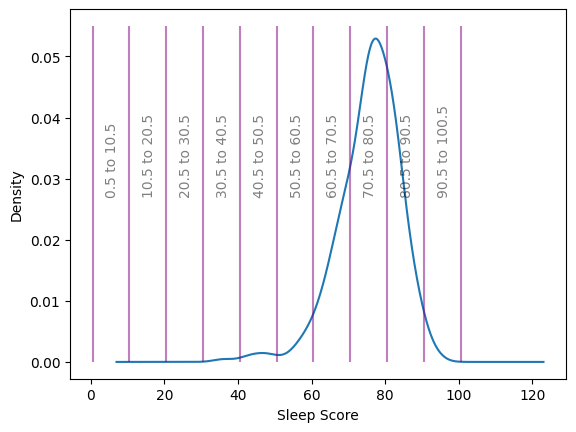

In [491]:
# Instead of having 0-100 potential label predictions when using a classification model,
# we should create a categorical 'binned' label column.
# Create bins. We can use .5 to easily decide left edge or right edge issues.
bin_number = 10
bin_interval_even = np.linspace(0.5, 100.5, bin_number + 1, dtype = float)
bin_labels = [f"{i} to {i + bin_number}" for i in bin_interval_even if i != bin_interval_even[-1]]
# np.digitize() can map the sleep scores to the correct bins
bin_idx = np.digitize(daily_sleep_score_df['score'], bin_interval_even, right = False)
# Create new column with the new bin labels
bin_map_even = [bin_labels[value - 1] for value in bin_idx]
daily_sleep_score_df['score_bin_even'] = bin_map_even
print(bin_labels)
display(daily_sleep_score_df['score_bin_even'].value_counts())

daily_sleep_score_df['score'].plot(kind='kde')
plt.vlines(bin_interval_even, ymin = 0, ymax = 0.055, color = 'purple', alpha = 0.5)
for idx, label in enumerate(bin_labels):
    plt.text(x = ((bin_interval_even[idx] + bin_interval_even[idx + 1]) / 2) - 1.5,
             y = (plt.ylim()[0] + plt.ylim()[1]) / 2,
             s = label,
             rotation = 'vertical',
             alpha = 0.5)
plt.xlabel('Sleep Score')

You'll notice that once overlaid the distribution of the sleep score data, there appears to be a lot of wasted bins that don't capture any data. Logically you would think to increase the bin size, reducing the total number, but you quickly run into a different problem. If you increase the bin size you risk having the majority of the data land in only a few classes, and arguably that's a problem with the parameters chosen here where the majority of the data will land in a few bins causing sever class imbalance. However, decreasing the bin size will arguably make the interpretability of the class boundaries worse and increase the outlier effects.

**Quantile/Median-Centered Bins**

---

The distribution of scores are split into 5 quantiles (quintiles) meaning each bin will divide the range of data into 1/5 bins. The bins here will be labeled and distributed between 5 bins: `['Worst', 'Bad', 'Avg', 'Good', 'Best']`. 

*Note: this and the follow method denotes an 'Avg' bin but in reality it is actually calculated using the median but they're close enough here that they effectively mean the same thing.*

Quantile Bins: [36. 69. 75. 78. 82. 94.]

Distribution of Bins: score
Bad      84
Worst    73
Best     68
Good     66
Avg      62
Name: count, dtype: int64


Text(0.5, 0, 'Sleep Score')

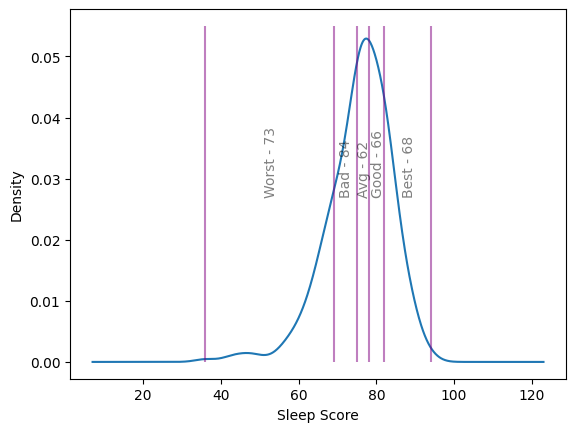

In [492]:
#labels_quantile = ['Worst', 'Bad', 'Below Avg','Above Avg', 'Good', 'Best']
labels_quantile = ['Worst', 'Bad', 'Avg', 'Good', 'Best']
bin_map_quantile, bin_interval_quantile = pd.qcut(daily_sleep_score_df['score'], 5, labels = labels_quantile, retbins = True)
daily_sleep_score_df['score_bin_quantile'] = bin_map_quantile

print('Quantile Bins:', bin_interval_quantile)
print('\nDistribution of Bins:', bin_map_quantile.value_counts())
daily_sleep_score_df['score'].plot(kind = 'kde')
plt.vlines(bin_interval_quantile, ymin = 0, ymax = 0.055, color = 'purple', alpha = 0.5)
for idx, label in enumerate(labels_quantile):
    plt.text(x = ((bin_interval_quantile[idx] + bin_interval_quantile[idx + 1]) / 2) - 1.5,
             y = (plt.ylim()[0] + plt.ylim()[1]) / 2,
             s = f'{label} - {bin_map_quantile.value_counts()[label]}',
             rotation = 'vertical',
             alpha = 0.5)
plt.xlabel('Sleep Score')

With very little parameter tweaking you can see the bin intervals overlaid on the distribution fits the data much better compared to the even-width method. This produced bins with reasonable balance that matches the data distribution. Another positive attribute of this method is the min and max interval starts at the min and max values of the data. You can see how this method will limit how outliers affect our classifications by way of naturally widening bins by a scalar of the standard deviation as they get further from the median value as there are less of those score values.

**Custom Quantile Bins**

---

The creation of this method isn't too dissimilar to the previous quantile bin implementation, but uses only the median and standard deviation to create each interval. Since this data is my own, the justifications were based on insights of my own perception of sleep quality (i.e., I believe my sleep generally skews towards poor sleep, therefore the bins and total number of classes in each should reflect that perception which is backed up here by the distribution's left tailedness.). In this method it was also determined to try 6 bins with the labels: `['Worst', 'Bad', 'Below Avg', 'Above Avg', 'Good', 'Best']`

*Note: I did not use any hard-coding to get these intervals, only the median and standard deviations so it will adjust when the data is updated, potentially shifting if my sleep consistently gets better.*

Custom Quantile Bins: [0, 64.39549639460978, 72.79849879820325, 77.0, 81.20150120179675, 89.60450360539022, 100]

Distribution of Bins: score
Below Avg    88
Good         78
Bad          77
Above Avg    75
Worst        30
Best          5
Name: count, dtype: int64


Text(0.5, 0, 'Sleep Score')

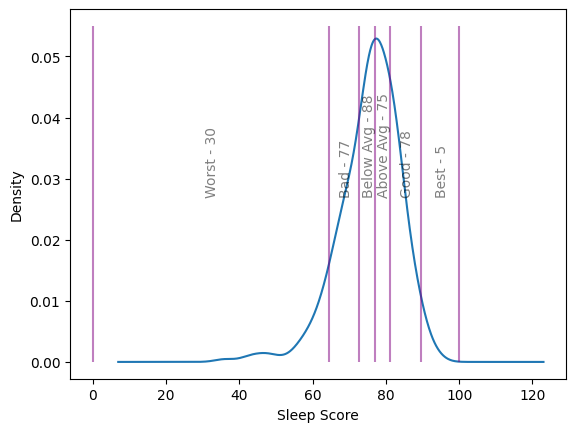

In [493]:
labels_custom = ['Worst', 'Bad', 'Below Avg', 'Above Avg', 'Good', 'Best']
median_score = daily_sleep_score_df['score'].median()
std_score = daily_sleep_score_df['score'].std()
bin_interval_custom = [0,
            median_score - (1.5 * std_score),
            median_score - (0.5 * std_score),
            median_score,
            median_score + (0.5 * std_score),
            median_score + (1.5 * std_score),
            100]
bin_map_custom = pd.cut(daily_sleep_score_df['score'], bins = bin_interval_custom, labels = labels_custom)
daily_sleep_score_df['score_bin_custom'] = bin_map_custom

print('Custom Quantile Bins:', bin_interval_custom)
print('\nDistribution of Bins:', bin_map_custom.value_counts())
daily_sleep_score_df['score'].plot(kind='kde')
plt.vlines(bin_interval_custom, ymin = 0, ymax = 0.055, color = 'purple', alpha = 0.5)
for idx, label in enumerate(labels_custom):
    plt.text(x = ((bin_interval_custom[idx] + bin_interval_custom[idx + 1]) / 2) - 1.5,
             y = (plt.ylim()[0] + plt.ylim()[1]) / 2,
             s = f'{label} - {bin_map_custom.value_counts()[label]}',
             rotation = 'vertical',
             alpha = 0.5)
plt.xlabel('Sleep Score')

This distribution of bins looks to match my personal domain knowledge that is my sleep quality, we'll see later how it performs.

Here we can take a look at a slice of the date with our new version of the target variable (y).

In [494]:
display(daily_sleep_score_df.tail(5))

,score,day,score_bin_even,score_bin_quantile,score_bin_custom
350,68,2024-02-02 00:00:00+00:00,60.5 to 70.5,Worst,Bad
351,76,2024-02-03 00:00:00+00:00,70.5 to 80.5,Avg,Below Avg
352,75,2024-02-04 00:00:00+00:00,70.5 to 80.5,Bad,Below Avg
353,83,2024-02-05 00:00:00+00:00,80.5 to 90.5,Best,Good
354,83,2024-02-06 00:00:00+00:00,80.5 to 90.5,Best,Good


Finally, now that we've extracted the features we wanted from `sleep_df`, we can total the multiple sleep entries per day and then combine the sleep metrics with the biometric data. 

*Note: some metrics are not summed in this process, and of those, only the metrics tied to the `'long_sleep'` entry will be used in the final dataset. (e.g., we don't really care what the average heart rate variability (`['average_hrv']`) or (`['latency']`) is for an interrupted sleep section during the night that only lasted 30 minutes.)*

In [495]:
# Sum each day's sleep metrics (important for days with interrupted sleep or naps).
# Overwrites each day's entry.
sleep_df = sleep_df[['day', 
         'deep_sleep_duration', 
         'light_sleep_duration', 
         'rem_sleep_duration', 
         'restless_periods', 
         'awake_time', 
         'time_in_bed', 
         'total_sleep_duration']].groupby(['day']).sum().reset_index()

# Features extracted only from the long sleep to include in the final dateframe.
sleep_df_long = sleep_df_long[['day', 
                               'average_breath', 
                               'average_heart_rate', 
                               'average_hrv', 
                               'latency', 
                               'lowest_heart_rate', 
                               'bedtime_start_delta',
                               'nap_today']]
# Merge the summed features with the long_sleep-only features.
sleep_df = sleep_df.merge(sleep_df_long, on = 'day', how = 'outer')
sleep_df.head(2)

,day,deep_sleep_duration,light_sleep_duration,rem_sleep_duration,restless_periods,awake_time,time_in_bed,total_sleep_duration,average_breath,average_heart_rate,average_hrv,latency,lowest_heart_rate,bedtime_start_delta,nap_today
0,2023-02-04 00:00:00+00:00,4650.0,15570.0,5820.0,282.0,4440.0,30480,26040.0,13.625,63.25,77.0,990.0,56.0,-4778,0
1,2023-02-05 00:00:00+00:00,4590.0,14970.0,9210.0,240.0,6210.0,34980,28770.0,15.125,92.49,19.0,180.0,75.0,-332,0


Now that all feature cleaning, creation, and transformations are complete we should verify each dataframe matches shape for the upcoming merge.

In [496]:
print('Verify all DF.shape matches:', sleep_df.shape[0] == biometric_df.shape[0] == daily_sleep_score_df.shape[0])
print(sleep_df.shape, '<-- sleep_df')
print(biometric_df.shape, '<-- biometric_df')
print(daily_sleep_score_df.shape, '<-- daily_sleep_score_df')

Verify all DF.shape matches: True
(353, 15) <-- sleep_df
(353, 13) <-- biometric_df
(353, 5) <-- daily_sleep_score_df


Now, let's create one dataframe for both the scores and features, then display them.

In [497]:
# Merge sleep and biometric DFs.
bio_sleep_df = sleep_df.merge(biometric_df, on = 'day', how = 'outer')
# Merge sleep score df and feature df.
bio_sleep_df = daily_sleep_score_df.merge(bio_sleep_df, on = 'day', how = 'outer')
bio_sleep_df.reset_index(drop = True, inplace = True)

display(bio_sleep_df)
print(bio_sleep_df.columns)

,score,day,score_bin_even,score_bin_quantile,score_bin_custom,deep_sleep_duration,light_sleep_duration,rem_sleep_duration,restless_periods,awake_time,...,low_activity_time,medium_activity_time,meters_to_target,non_wear_time,resting_time,sedentary_time,steps,total_calories,temperature_deviation,spo2_percentage
0,81,2023-02-04 00:00:00+00:00,80.5 to 90.5,Good,Above Avg,4650.0,15570.0,5820.0,282.0,4440.0,...,8460,120,6300,36000,19680,22140,2718,2429,NaN,NaN
1,81,2023-02-05 00:00:00+00:00,80.5 to 90.5,Good,Above Avg,4590.0,14970.0,9210.0,240.0,6210.0,...,23220,2940,0,0,25740,34380,11638,3075,-0.38,98.523
2,89,2023-02-06 00:00:00+00:00,80.5 to 90.5,Best,Good,8580.0,15210.0,7350.0,302.0,6240.0,...,15000,2580,2700,0,35280,33480,9001,2814,-0.04,97.181
3,78,2023-02-07 00:00:00+00:00,70.5 to 80.5,Avg,Above Avg,4500.0,17700.0,6030.0,284.0,5010.0,...,13440,2160,5300,0,31080,39600,7544,2748,-0.22,99.177
4,80,2023-02-08 00:00:00+00:00,70.5 to 80.5,Good,Above Avg,4920.0,15630.0,6420.0,245.0,6210.0,...,16560,3180,2300,4800,31020,30840,8668,2852,-0.25,98.634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,68,2024-02-02 00:00:00+00:00,60.5 to 70.5,Worst,Bad,4890.0,13800.0,4890.0,197.0,9753.0,...,18000,5400,-4400,60,26700,36120,13714,3151,-0.22,96.706
349,76,2024-02-03 00:00:00+00:00,70.5 to 80.5,Avg,Below Avg,5220.0,17790.0,4770.0,215.0,9180.0,...,20820,3660,-3700,1020,36420,24360,13388,3092,-0.71,99.200
350,75,2024-02-04 00:00:00+00:00,70.5 to 80.5,Bad,Below Avg,4980.0,13770.0,4950.0,203.0,9386.0,...,15840,4260,-2800,3600,30780,31860,13186,3016,-0.60,98.131
351,83,2024-02-05 00:00:00+00:00,80.5 to 90.5,Best,Good,7140.0,12990.0,7320.0,187.0,6501.0,...,13260,2520,400,360,31680,38400,8380,2773,-0.48,98.595


Index(['score', 'day', 'score_bin_even', 'score_bin_quantile',
       'score_bin_custom', 'deep_sleep_duration', 'light_sleep_duration',
       'rem_sleep_duration', 'restless_periods', 'awake_time', 'time_in_bed',
       'total_sleep_duration', 'average_breath', 'average_heart_rate',
       'average_hrv', 'latency', 'lowest_heart_rate', 'bedtime_start_delta',
       'nap_today', 'active_calories', 'high_activity_time',
       'low_activity_time', 'medium_activity_time', 'meters_to_target',
       'non_wear_time', 'resting_time', 'sedentary_time', 'steps',
       'total_calories', 'temperature_deviation', 'spo2_percentage'],
      dtype='object')


Lastly, we need to see what data is missing from our final dataframe and rectify any issues found. For now, as to not alter the distribution of  the features any NaN value will be replaced with the median value of that feature.

In [498]:
# Explore and deal with NaN values.
# A good option to deal with each feature individually.
# >>> values = {{"Feature 1": .median(), "Feature 2": 0, "Feature 3: .mean()}}
# >>> df.fillna(value=values)
# Only feature with NaN currently is SPO2 and temp. deviation, using median for now.
# TODO: Come back and tune each feature.
print('Columns with NaNs present:', bio_sleep_df.columns[bio_sleep_df.isna().any()].to_list())
print(f"{'':<5}Total number of NaNs: {bio_sleep_df.isna().sum(axis = 1).sum()}")
for column in bio_sleep_df:
    if bio_sleep_df[column].dtype == 'float64' or bio_sleep_df[column].dtype == 'int64':
        bio_sleep_df[column].fillna(bio_sleep_df[column].median(), inplace = True)
    else:
        continue
print(f'Number of NaN values remaining after adjustments: {bio_sleep_df.isna().sum(axis = 1).sum()}')

Columns with NaNs present: ['temperature_deviation', 'spo2_percentage']
     Total number of NaNs: 48
Number of NaN values remaining after adjustments: 0


### Exploratory Data Analysis (EDA)

In [499]:
bio_sleep_df.describe()

,score,deep_sleep_duration,light_sleep_duration,rem_sleep_duration,restless_periods,awake_time,time_in_bed,total_sleep_duration,average_breath,average_heart_rate,...,low_activity_time,medium_activity_time,meters_to_target,non_wear_time,resting_time,sedentary_time,steps,total_calories,temperature_deviation,spo2_percentage
count,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,...,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000
mean,75.597734,5265.042493,15382.776204,5475.042493,244.045326,6445.603399,32571.694051,26122.861190,13.884561,65.803088,...,17263.682720,3128.838527,-1493.484419,2969.745042,31003.342776,31844.362606,10819.963173,2940.813031,0.007450,97.842986
std,8.403002,1667.128745,2500.618719,1456.503659,54.461654,2899.808704,4112.171365,3212.363992,0.481592,7.836005,...,4813.519199,1855.161430,4482.521299,6154.118003,4777.300153,6612.383545,3447.932402,247.672000,0.216197,0.851728
min,36.000000,210.000000,9150.000000,1110.000000,88.000000,1590.000000,19740.000000,14040.000000,12.750000,49.400000,...,900.000000,120.000000,-38700.000000,0.000000,8280.000000,5040.000000,1601.000000,2229.000000,-0.710000,92.072000
25%,71.000000,4320.000000,13710.000000,4590.000000,211.000000,4555.000000,30221.000000,24060.000000,13.625000,60.240000,...,13980.000000,2160.000000,-3700.000000,0.000000,28800.000000,27360.000000,8522.000000,2802.000000,-0.110000,97.472000
50%,77.000000,5130.000000,15300.000000,5490.000000,239.000000,5940.000000,32460.000000,26280.000000,13.875000,64.170000,...,16860.000000,2820.000000,-800.000000,360.000000,31380.000000,32640.000000,10388.000000,2917.000000,0.020000,98.027000
75%,81.000000,6120.000000,17040.000000,6390.000000,280.000000,7560.000000,35345.000000,28080.000000,14.125000,69.730000,...,19920.000000,3720.000000,1100.000000,3480.000000,33900.000000,36660.000000,12708.000000,3060.000000,0.120000,98.419000
max,94.000000,10200.000000,21690.000000,9420.000000,492.000000,27456.000000,51036.000000,35520.000000,15.875000,96.680000,...,36240.000000,24660.000000,8900.000000,51840.000000,49260.000000,50160.000000,23382.000000,5036.000000,1.420000,99.200000


In [500]:
# Function to transform inputs from seconds to hours.
def sec_to_hours(seconds):
    return seconds / 60 / 60

print('Total Sleep in Hours:')
sec_to_hours(bio_sleep_df['total_sleep_duration'].describe())

Total Sleep in Hours:


count    0.098056
mean     7.256350
std      0.892323
min      3.900000
25%      6.683333
50%      7.300000
75%      7.800000
max      9.866667
Name: total_sleep_duration, dtype: float64

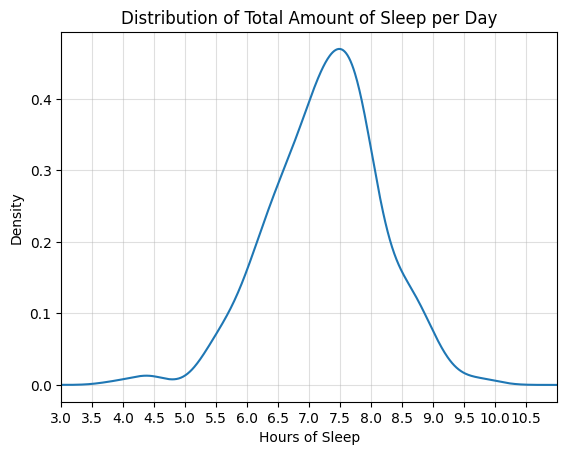

In [501]:
x_min = min(sec_to_hours(bio_sleep_df['total_sleep_duration']))
x_max = max(sec_to_hours(bio_sleep_df['total_sleep_duration']))
sec_to_hours(bio_sleep_df['total_sleep_duration']).plot(kind = 'kde')
plt.title('Distribution of Total Amount of Sleep per Day')
plt.xlabel('Hours of Sleep')
plt.xticks(np.arange(round(x_min - 1), round(x_max + 1), 0.5))
plt.xlim(round(x_min - 1), round(x_max + 1))
plt.grid(alpha = 0.4)

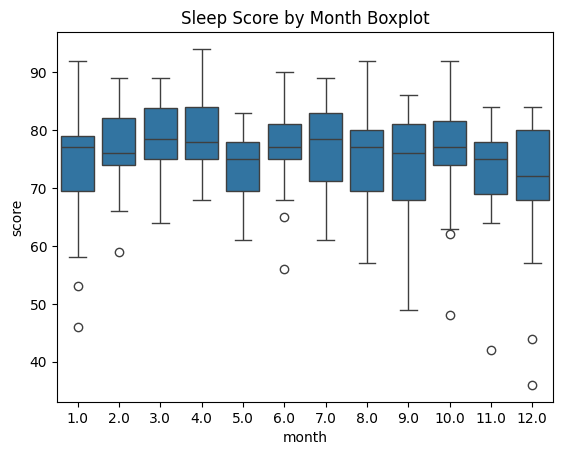

In [502]:
ax = sns.boxplot(x = bio_sleep_df['day'].dt.month, y = daily_sleep_score_df['score'])
ax.set(title = 'Sleep Score by Month Boxplot', xlabel = 'month')
plt.show()

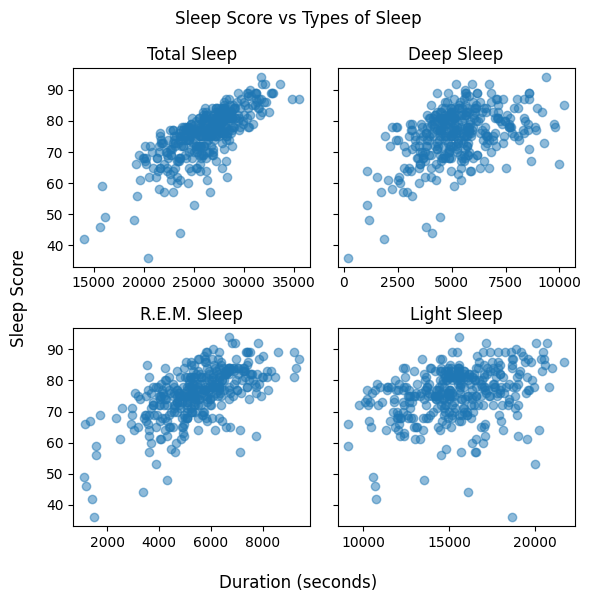

In [503]:
fig, ax = plt.subplots(2,2, figsize = (6, 6), sharey = True)

ax[0, 0].scatter(bio_sleep_df['total_sleep_duration'], bio_sleep_df['score'], alpha = 0.5)
ax[0, 0].set_title('Total Sleep')
ax[0, 1].scatter(bio_sleep_df['deep_sleep_duration'], bio_sleep_df['score'], alpha = 0.5)
ax[0, 1].set_title('Deep Sleep')
ax[1, 0].scatter(bio_sleep_df['rem_sleep_duration'], bio_sleep_df['score'], alpha = 0.5)
ax[1, 0].set_title('R.E.M. Sleep')
ax[1, 1].scatter(bio_sleep_df['light_sleep_duration'], bio_sleep_df['score'], alpha = 0.5)
ax[1, 1].set_title('Light Sleep')

fig.suptitle('Sleep Score vs Types of Sleep')
fig.supxlabel('Duration (seconds)')
fig.supylabel('Sleep Score')
fig.tight_layout()

In [504]:
bio_sleep_df['steps'].describe()

count      353.000000
mean     10819.963173
std       3447.932402
min       1601.000000
25%       8522.000000
50%      10388.000000
75%      12708.000000
max      23382.000000
Name: steps, dtype: float64

In [505]:
# Remove day column in preparation for model training.
bio_sleep_df.drop(['day'], axis = 1, inplace = True)

In [506]:
bio_sleep_df

,score,score_bin_even,score_bin_quantile,score_bin_custom,deep_sleep_duration,light_sleep_duration,rem_sleep_duration,restless_periods,awake_time,time_in_bed,...,low_activity_time,medium_activity_time,meters_to_target,non_wear_time,resting_time,sedentary_time,steps,total_calories,temperature_deviation,spo2_percentage
0,81,80.5 to 90.5,Good,Above Avg,4650.0,15570.0,5820.0,282.0,4440.0,30480,...,8460,120,6300,36000,19680,22140,2718,2429,0.02,98.027
1,81,80.5 to 90.5,Good,Above Avg,4590.0,14970.0,9210.0,240.0,6210.0,34980,...,23220,2940,0,0,25740,34380,11638,3075,-0.38,98.523
2,89,80.5 to 90.5,Best,Good,8580.0,15210.0,7350.0,302.0,6240.0,37380,...,15000,2580,2700,0,35280,33480,9001,2814,-0.04,97.181
3,78,70.5 to 80.5,Avg,Above Avg,4500.0,17700.0,6030.0,284.0,5010.0,33240,...,13440,2160,5300,0,31080,39600,7544,2748,-0.22,99.177
4,80,70.5 to 80.5,Good,Above Avg,4920.0,15630.0,6420.0,245.0,6210.0,33180,...,16560,3180,2300,4800,31020,30840,8668,2852,-0.25,98.634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,68,60.5 to 70.5,Worst,Bad,4890.0,13800.0,4890.0,197.0,9753.0,33333,...,18000,5400,-4400,60,26700,36120,13714,3151,-0.22,96.706
349,76,70.5 to 80.5,Avg,Below Avg,5220.0,17790.0,4770.0,215.0,9180.0,36960,...,20820,3660,-3700,1020,36420,24360,13388,3092,-0.71,99.200
350,75,70.5 to 80.5,Bad,Below Avg,4980.0,13770.0,4950.0,203.0,9386.0,33086,...,15840,4260,-2800,3600,30780,31860,13186,3016,-0.60,98.131
351,83,80.5 to 90.5,Best,Good,7140.0,12990.0,7320.0,187.0,6501.0,33951,...,13260,2520,400,360,31680,38400,8380,2773,-0.48,98.595


<Axes: >

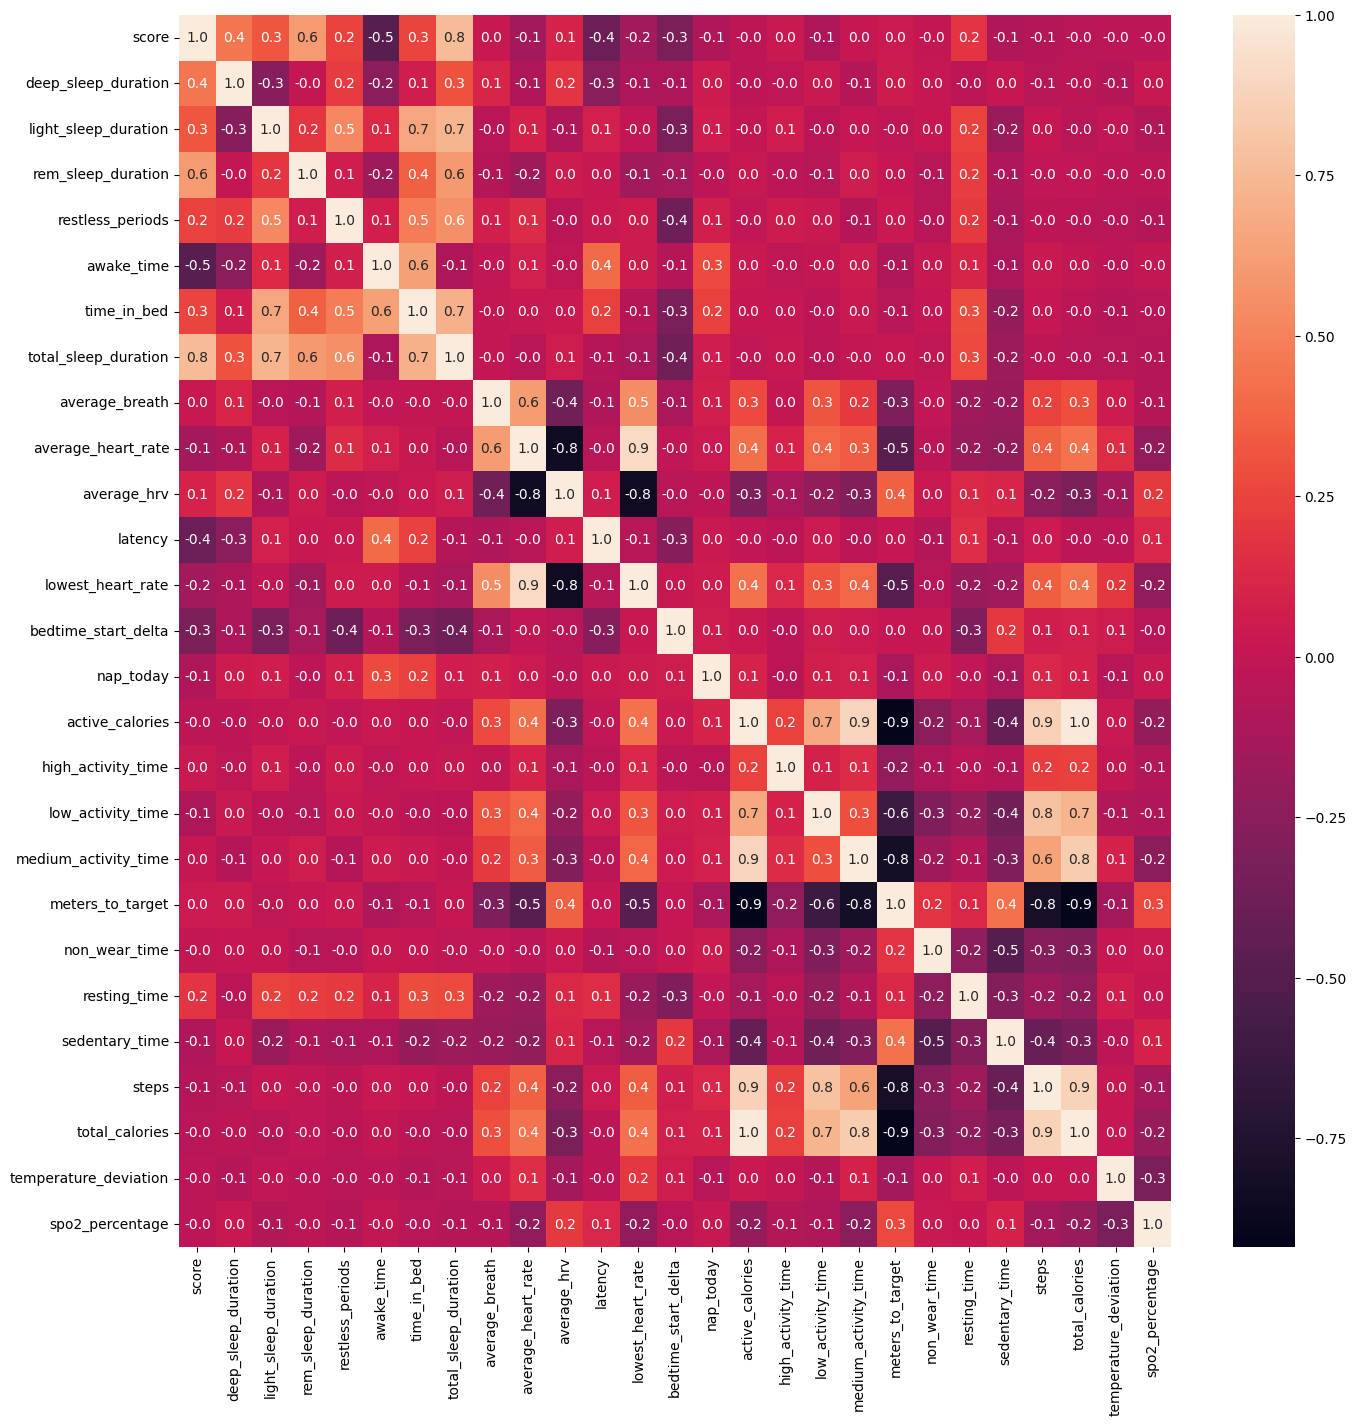

In [507]:
# Correlation
# Include score column but drop categorical bins to see correlation between response and predictors too.
corr_matrix = bio_sleep_df.drop(['score_bin_even', 'score_bin_quantile', 'score_bin_custom'], axis = 1).corr()
# Plot matrix.
fig, ax = plt.subplots(figsize = (16, 16))
sns.heatmap(corr_matrix, ax = ax, annot = True, fmt = '.1f')

[ ANALYSIS HERE ]

In [508]:
bio_sleep_df[['bedtime_start_delta']].describe()

,bedtime_start_delta
count,353.000000
mean,-1218.929178
std,3302.654300
min,-14398.000000
25%,-3177.000000
50%,-1109.000000
75%,629.000000
max,13351.000000


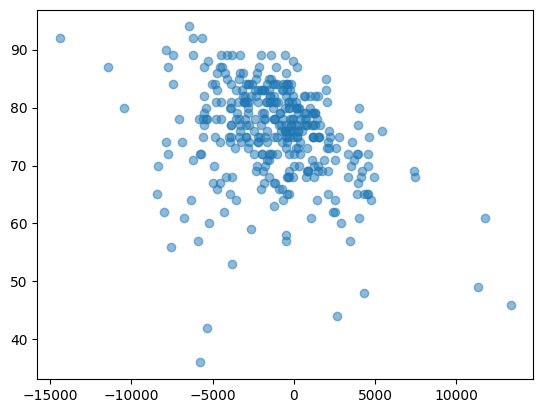

In [509]:
plt.scatter(bio_sleep_df['bedtime_start_delta'], bio_sleep_df['score'], alpha = 0.5)

In [510]:
late_bedtime_scores = bio_sleep_df[bio_sleep_df['bedtime_start_delta'] > 0]['score']
early_bedtime_scores = bio_sleep_df[bio_sleep_df['bedtime_start_delta'] < 0]['score']
# As our intention is a two-sample t-test we need to verify if our sample variances indicate equal population variances.
# We can do this with an F-test, IF the samples come from a normal distribution.
# Let's test if our samples display normality with the shapiro-wilk test.
# Null hypothesis H_0: samples come from a normal distribution.
t_stat_sw, p_value_sw = stats.shapiro(bio_sleep_df['score'])
if p_value_sw > 0.05:
    print(f"Shapiro-Wilk test (Normality): \n{'':<5}with a p-value of {p_value_sw}, \n{'':<5}we fail to reject the null hypothesis: samples are from a normally distributed population.")
else:
    print(f"Shapiro-Wilk test (Normality): \n{'':<5}with a p-value of {p_value_sw}, \n{'':<5}we successfully reject the null hypothesis: samples are from a normally distributed population.")

# We can't use the F-test under these circumstances, but can instead use the levene test to test for equal variances.
# Null hypothesis H_0: Var(late) == Var(early)
t_stat_lev, p_value_lev = stats.levene(late_bedtime_scores, early_bedtime_scores)
p_value_lev
if p_value_lev > 0.05:
    print(f"Levene test (variance): \n{'':<5}with a p-value of {p_value_lev}, \n{'':<5}we fail to reject the null hypothesis: Var(late) == Var(early)")
else:
    print(f"Levene test (variance): \n{'':<5}with a p-value of {p_value_lev}, \n{'':<5}we successfully reject the null hypothesis: Var(late) == Var(early)")

# Finally let's perform a t-test to see if the mean scores are equal or not depending on the sleep time.
# Null hypothesis H_0: mean(late) == mean(early)
t_stat_t, p_value_t = stats.ttest_ind(late_bedtime_scores, early_bedtime_scores, alternative = 'two-sided')
if p_value_t > 0.05:
    print(f"Two-Sample T-test (mean): \n{'':<5}with a p-value of {p_value_t}, \n{'':<5}we fail to reject the null hypothesis: mean(late) == mean(early)")
else:
    print(f"Two-Sample T-test (mean): \n{'':<5}with a p-value of {p_value_t}, \n{'':<5}we successfully reject the null hypothesis: mean(late) == mean(early)")

Shapiro-Wilk test (Normality): 
     with a p-value of 5.418651083388681e-10, 
     we successfully reject the null hypothesis: samples are from a normally distributed population.
Levene test (variance): 
     with a p-value of 0.5648771683898552, 
     we fail to reject the null hypothesis: Var(late) == Var(early)
Two-Sample T-test (mean): 
     with a p-value of 4.0880002322588927e-07, 
     we successfully reject the null hypothesis: mean(late) == mean(early)


Let's fit a linear regression model to the `['score']` response. This should help us identify important features and give a good idea how well our data will be in creating an accurate model.

In [511]:
# Create predictors list for model
# Remove first few columns (scores)
# ols_predictors = (bio_sleep_df.columns[4:]).to_list()
# ols_pred_string = ''
# for i in ols_predictors:
#     ols_pred_string = f'{ols_pred_string} + {i}'

# linear_clf = smf.ols(formula = f'score ~ {ols_pred_string[3:]}', data = bio_sleep_df).fit()
# linear_clf.summary()

linear_clf = sm.OLS(bio_sleep_df.iloc[:, :1], sm.add_constant(bio_sleep_df.iloc[:, 4:])).fit()
linear_clf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     101.0
Date:                Tue, 06 Feb 2024   Prob (F-statistic):          1.30e-137
Time:                        19:21:26   Log-Likelihood:                -869.51
No. Observations:                 353   AIC:                             1791.
Df Residuals:                     327   BIC:                             1892.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     4.3622     28.532      0.153      0.879     -51.768      60.493
deep_sleep_duration      -0.0005      0.001     -0.550      0.583      -0.002       0.001
light_sleep_duration     -0.0014      0.001     -1.458      0.146      -0.003       0.000
rem_sleep_duration    -5.281e-05      0.001     -0.056      0.955      -0.002       0.002
restless_periods         -0.0221      0.004     -5.402      0.000      -0.030      -0.014
awake_time               -0.0053      0.004     -1.426      0.155      -0.013       0.002
time_in_bed               0.0047      0.004      1.253      0.211      -0.003       0.012
total_sleep_duration     -0.0019      0.003     -0.692      0.489      -0.007       0.004
average_breath            0.3119      0.478      0.653      0.514      -0.628       1.252
average_heart_rate       -0.0980      0.071     -1.389      0.166      -0.237       0.041
average_hrv              -0.0070      0.014     -0.487      0.626      -0.035       0.021
latency                  -0.0021      0.000    -12.681      0.000      -0.002      -0.002
lowest_heart_rate         0.0248      0.060      0.413      0.680      -0.093       0.143
bedtime_start_delta      -0.0006   6.11e-05     -9.205      0.000      -0.001      -0.000
nap_today                -0.6323      0.557     -1.134      0.257      -1.729       0.464
active_calories          -0.0025      0.010     -0.257      0.797      -0.022       0.017
high_activity_time        0.0005      0.001      0.329      0.742      -0.002       0.003
low_activity_time        -0.0001      0.000     -0.642      0.521      -0.001       0.000
medium_activity_time     -0.0002      0.000     -0.490      0.624      -0.001       0.001
meters_to_target      -4.253e-05      0.000     -0.416      0.678      -0.000       0.000
non_wear_time          7.165e-05      0.000      0.565      0.572      -0.000       0.000
resting_time              0.0001      0.000      1.042      0.298      -0.000       0.000
sedentary_time          6.74e-05      0.000      0.490      0.624      -0.000       0.000
steps                  2.323e-05      0.000      0.195      0.845      -0.000       0.000
total_calories            0.0065      0.009      0.719      0.473      -0.011       0.024
temperature_deviation     0.3037      0.828      0.367      0.714      -1.325       1.932
spo2_percentage           0.1547      0.210      0.736      0.462      -0.259       0.568
==============================================================================
Omnibus:                       18.471   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.825
Skew:                          -0.438   Prob(JB):                     6.71e-06
Kurtosis:                       3.924   Cond. No.                  

#### Feature Selection/Removal

In [512]:
# Remove sign on correlation score for comparison.
# TODO: This method arbitrarily selects the first feature (of the two with a high score)
#   that it comes across. Change this method to have an insight-based selection method.
#   Possibly a preference list.
corr_matrix_abs = corr_matrix.abs()
# Drop score from x and y axis.
corr_matrix_abs.drop('score', axis = 0, inplace = True)
corr_matrix_abs.drop('score', axis = 1, inplace = True)
# Mask off only one of the correlation triangles to avoid duplicates.
corr_triangle = corr_matrix_abs.where(np.triu(np.ones(corr_matrix_abs.shape), k = 1).astype(bool))
# Create list of features with correlation higher than a threshold.
# Threshold set to > 0.75
to_drop = [column for column in corr_triangle.columns if any(corr_triangle[column] > 0.7)]
print(to_drop)

['total_sleep_duration', 'average_hrv', 'lowest_heart_rate', 'medium_activity_time', 'meters_to_target', 'steps', 'total_calories']


For now let's manually remove features (see TODO note above).

In [513]:
choices_to_drop = [('average_hrv', 'average_heart_rate'), # average_heart
           ('lowest_heart_rate', 'average_hrv'), # average hrv
           ('medium_activity_time', 'active_calories'), # active
           ('meters_to_target', 'active_calories'), # both
           ('steps', 'alot'), # steps
           ('total_calories', 'alot')] # total calories

bio_sleep_df.drop(['lowest_heart_rate', 
                   'active_calories', 
                   'meters_to_target', 
                   'steps', 
                   'total_calories', 
                   'average_heart_rate', 
                   'time_in_bed', 
                   'total_sleep_duration'],
                  axis = 1, inplace = True)

<Axes: >

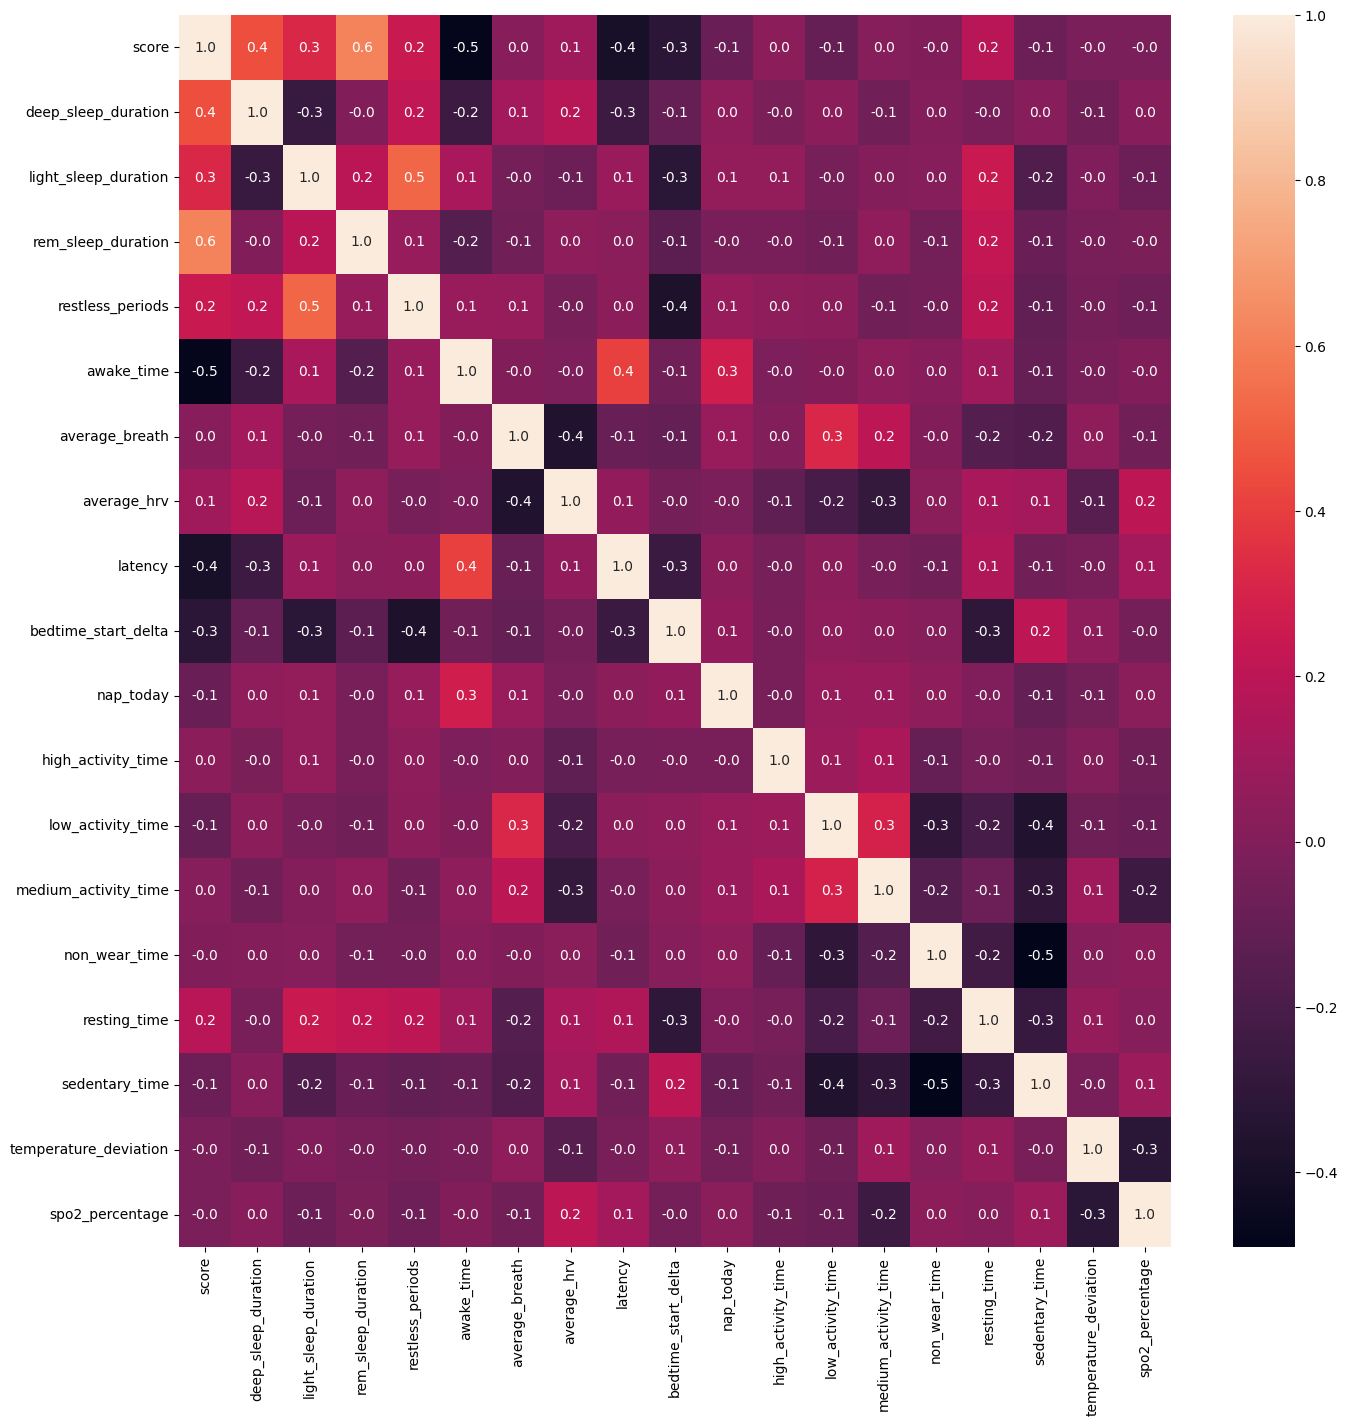

In [514]:
# Correlation
# Include score column to see correlation between response and predictors too.
corr_matrix = bio_sleep_df.drop(['score_bin_even', 'score_bin_quantile', 'score_bin_custom'], axis = 1).corr()
# Plot matrix.
fig, ax = plt.subplots(figsize = (16, 16))
sns.heatmap(corr_matrix, ax = ax, annot = True, fmt = '.1f')

Subset Feature Selection / Backwards Feature Selection starting from all features.

In [515]:
# Move this above feature removal and maybe make yet another DF set for recursive optimization vs manual feature removal.

#### Outlier Removal

In [516]:
# Identify any score_bin_even where that class n == 1
display(bio_sleep_df['score_bin_even'].value_counts())
one_class = (bio_sleep_df['score_bin_even'].value_counts() == 1)
one_class_drop = (one_class.loc[one_class == True].index)
# Remove outlier for now so we can class-balance the splits (min per class required = 2)
for value in one_class_drop:
    class_outlier_loc = bio_sleep_df.loc[bio_sleep_df['score_bin_even'] == value]
    bio_sleep_df.drop(class_outlier_loc.index, axis = 0, inplace = True)
    
bio_sleep_df.reset_index(drop = True, inplace = True)

score_bin_even
70.5 to 80.5     165
80.5 to 90.5     101
60.5 to 70.5      68
50.5 to 60.5       9
40.5 to 50.5       5
90.5 to 100.5      4
30.5 to 40.5       1
Name: count, dtype: int64

#### Standardize Features
Since we'll be using many machine learning models in which regularization techniques are sensitive to differences in predictor variance magnitudes/scale (e.g., Lasso/Ridge Regression, SVM, etc.) and expect features to be roughly normally distributed, we will be standardizing features appropriately.

Standardization will be done with the following formula:


$$Z = \frac{(X - \bar{X})}{S}$$

Centers inputs around 0 with the sample mean, and scales them with the sample standard deviation.


##### Train Test Split

Since we'll be using sklearn's StandardScaler() to standardize, we need to do the split at the same time so that we can properly separate the training information from the test set during standardization, preventing data leakage.

In total we will have 3 types of train / test splits to use on our models, but they will be split identically. We can also use the `stratify` parameter to class balance the training and test sets which will help generalize models training on this fairly sparse dataset.

In [517]:
rand_state = 6829 #472453 #98784 # Used in all classifiers
test_ratio = 0.2
bin_type = 'score_bin_quantile'

# Discretized Scores
# Stratify-balance the classes with the bin column (note this will slightly alter regression scores too).
X_train, X_test, y_train, y_test = train_test_split(bio_sleep_df.iloc[:, 4:], bio_sleep_df.iloc[:, :4], 
                                                    test_size = test_ratio, 
                                                    random_state = rand_state)#, 
                                                    #stratify = bio_sleep_df['score_bin_custom'])

# Binned/Categorical Class Labels
y_train_bin, y_test_bin = y_train[bin_type], y_test[bin_type]

# Centered and Standardized
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = scaler.get_feature_names_out())
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = scaler.get_feature_names_out())
# Squeeze y's to put into a series, same format as train_test_split
y_train_scaled = pd.DataFrame(scaler.fit_transform(np.array(y_train['score']).reshape(-1, 1)), columns = ['score_scaled']).squeeze(axis = 1)
y_test_scaled = pd.DataFrame(scaler.transform(np.array(y_test['score']).reshape(-1, 1)), columns = ['score_scaled']).squeeze(axis = 1)

### Helper Functions

In [518]:
from matplotlib.colors import Normalize
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
def plotSearchGrid(grid):
    
    scores = [x for x in grid.cv_results_["mean_test_score"]]
    scores = np.array(scores).reshape(len(grid.param_grid['max_depth']), len(grid.param_grid['max_leaf_nodes']))

    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
    plt.xlabel('max_leaf_nodes')
    plt.ylabel('max_depth')
    plt.colorbar()
    plt.xticks(np.arange(len(grid.param_grid['max_leaf_nodes'])), grid.param_grid['max_leaf_nodes'], rotation=90)
    plt.yticks(np.arange(len(grid.param_grid['max_depth'])), grid.param_grid['max_depth'])
    plt.title('Validation accuracy')
    plt.show()
    
def plotSearchGridSVM(grid):
    
    scores = [x for x in grid.cv_results_["mean_test_score"]]
    scores = np.array(scores).reshape(len(grid.param_grid['C']), len(grid.param_grid['gamma']))

    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
    plt.xlabel('Gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(grid.param_grid['gamma'])), grid.param_grid['gamma'], rotation=90)
    plt.yticks(np.arange(len(grid.param_grid['C'])), grid.param_grid['C'])
    plt.title('Validation accuracy')
    plt.show()

### Model Selection

---

Something we haven't discussed yet, besides in the realm of feature engineering, is whether or not regression or logistic regression makes more sense for this type of problem. 

First thing to note, because this isn't a binary logistic classification problem since we've binned our target variable into multiple classes the way we handle this is important and the sklearn package handles each model a little differently. Methods we'll use to handle this multi-class, sometimes called multinomial, classification problem is to utilize One-vs-Rest, One-vs-One, and Multinomial Loss (aka Cross Entropy) techniques. These methods will handle this issue of multiple classes fine, but we need to ask what we're looking for out of this.

Given the predictor variables and expected prediction, are we expecting a:
- Precise, continuous or discrete, sleep score predictions (Regression)?
  - How do we measure a successful prediction?
    - Is the standard error of each $\hat{y_i}$ within a range of the ground truth $y_i$.
    - Root Mean Squared Error (RMSE)
    - Mean Absolute Error (MAE)
- Predicted classes of sleep quality given by binned sleep scores indicating different levels of 'Bad', 'Good', 'Better', 'Best' sleep.
  - How do we measure a successful prediction?
    - Accuracy
    - F1 Score
    - ROC Curve

It's very important to note that comparing regression and classification models is almost always a fools-errand in building a convincing metric that can relate between the two types of models. In practice, it's better to properly formulate the question beforehand and fit the models that better answer that question instead of fitting them all and attempting to compare things that can't be directly compared.

All that said, because this is just an exercise, let's go ahead and do just that by creating a few of each of regression and logistic regression models and discuss this further in the conclusion section.

In [519]:
# Initialize list of fit model objects.
models_regression = []
models_classification = []

#### Linear Regression / Logistic Classification

After standardization, feature, and outlier removal let's see how the metrics associated with the linear regression model has changed.

*Note: in comparison with the previous regression model fit during the EDA section, which was only used for feature exploration, this model has been fit with only the training data split. Still, we can still draw some useful conclusions from this model*

In [520]:
mod_linear_OLS = sm.OLS(y_train['score'].reset_index(drop = True), sm.add_constant(X_train_scaled)).fit()
models_regression.append(mod_linear_OLS)
mod_linear_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     102.1
Date:                Tue, 06 Feb 2024   Prob (F-statistic):          3.80e-107
Time:                        19:21:26   Log-Likelihood:                -686.89
No. Observations:                 281   AIC:                             1412.
Df Residuals:                     262   BIC:                             1481.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    75.7758      0.172    439.849      0.000      75.437      76.115
deep_sleep_duration       3.5611      0.231     15.383      0.000       3.105       4.017
light_sleep_duration      3.2786      0.242     13.560      0.000       2.803       3.755
rem_sleep_duration        3.8484      0.184     20.945      0.000       3.487       4.210
restless_periods         -0.9551      0.238     -4.018      0.000      -1.423      -0.487
awake_time               -1.9694      0.196    -10.073      0.000      -2.354      -1.584
average_breath           -0.0550      0.205     -0.269      0.788      -0.458       0.348
average_hrv               0.2415      0.206      1.174      0.241      -0.163       0.646
latency                  -2.2924      0.202    -11.366      0.000      -2.690      -1.895
bedtime_start_delta      -1.8540      0.215     -8.639      0.000      -2.277      -1.431
nap_today                -0.0827      0.182     -0.454      0.650      -0.442       0.276
high_activity_time        0.1482      0.194      0.763      0.446      -0.234       0.531
low_activity_time        -0.2379      0.546     -0.436      0.663      -1.313       0.837
medium_activity_time      0.4478      0.307      1.458      0.146      -0.157       1.053
non_wear_time             0.2953      0.735      0.402      0.688      -1.152       1.743
resting_time              0.5991      0.513      1.168      0.244      -0.411       1.609
sedentary_time            0.4400      0.813      0.542      0.589      -1.160       2.040
temperature_deviation    -0.0728      0.186     -0.391      0.696      -0.439       0.294
spo2_percentage           0.0960      0.195      0.492      0.623      -0.289       0.481
==============================================================================
Omnibus:                        7.163   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                7.092
Skew:                          -0.328   Prob(JB):                       0.0288
Kurtosis:                       3.418   Cond. No.                         11.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

[ ANALYSIS ]

Note the condition number! Standardization and removal of features made quite the difference in multicollinearity there.

In [521]:
mod_log_regression = LogisticRegression(solver = 'lbfgs', multi_class = 'multinomial', max_iter = 15000, random_state = rand_state).fit(X_train, y_train_bin)
models_classification.append(mod_log_regression)

mod_lin_regression = LinearRegression().fit(X_train, y_train['score'])
models_regression.append(mod_lin_regression)

mod_ridge_regression = Ridge(max_iter = 10000, random_state = rand_state).fit(X_train, y_train['score'])
models_regression.append(mod_ridge_regression)

mod_ridge_classifier = RidgeClassifier(max_iter = 10000, random_state = rand_state).fit(X_train, y_train_bin)
models_classification.append(mod_ridge_classifier)

mod_lasso_regression = Lasso(max_iter = 10000, random_state = rand_state).fit(X_train, y_train['score'])
models_regression.append(mod_lasso_regression)

#### Support Vector Machine (SVM)

For hyperparameter tuning we will use a grid search with a range of C and Gamma values, and apply 3-fold cross-validation.

In [522]:
params = {'C': np.logspace(6, 10, base = 2), 'gamma': np.logspace(-10, 0, base = 2)}
grid_svm_regression = GridSearchCV(SVR(kernel = 'rbf'), param_grid = params, cv = 3).fit(X_train_scaled, y_train['score'])
mod_svm_regression = grid_svm_regression.best_estimator_
models_regression.append(mod_svm_regression)

grid_svm_classifier = GridSearchCV(SVC(kernel = 'rbf', random_state = rand_state, probability = True), param_grid = params, cv = 3).fit(X_train_scaled, y_train_bin)
mod_svm_classifier = grid_svm_classifier.best_estimator_
models_classification.append(mod_svm_classifier)

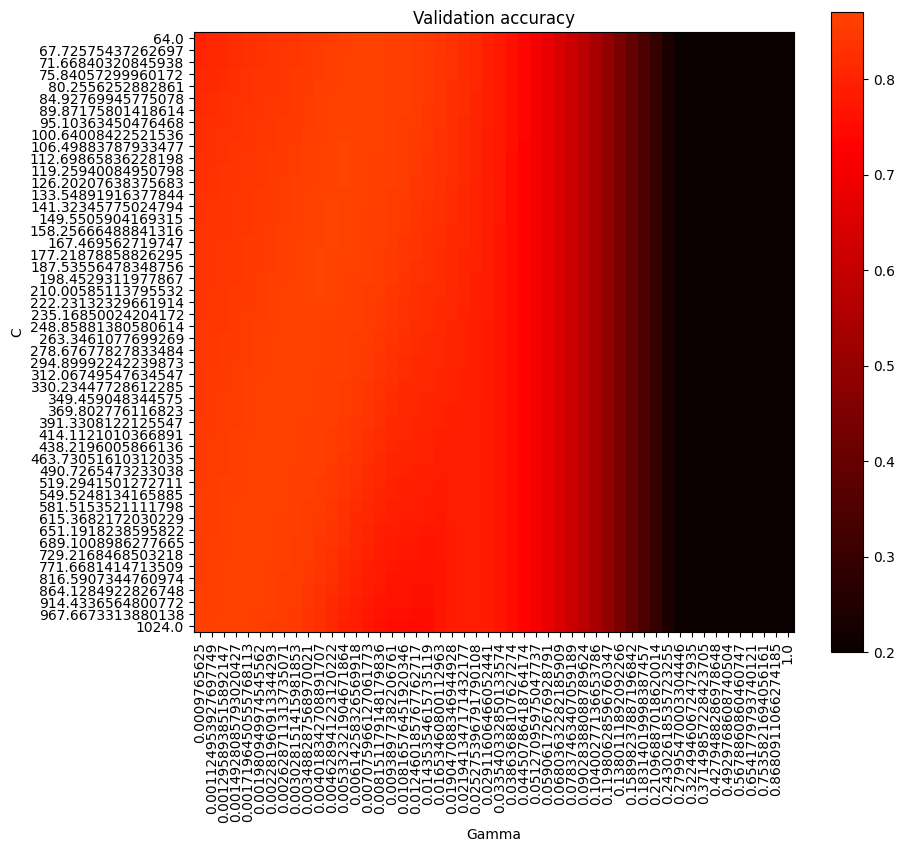

GridSearch results indicate the optimized parameters are, 
C: 158.25666488841316, Gamma: 0.004628941223120222, Validation Accuracy: 0.8699975676721913
0.8309859154929577


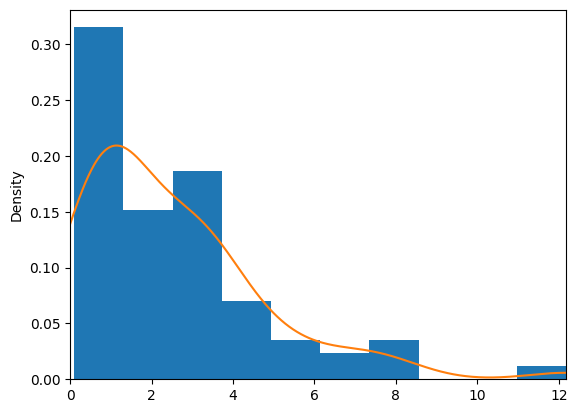

In [523]:
plotSearchGridSVM(grid_svm_regression)

scores = [x for x in grid_svm_regression.cv_results_["mean_test_score"]]

max_index = scores.index(max(scores))
max_score = max(scores)
opt_C = grid_svm_regression.cv_results_['param_C'][max_index]
opt_Gamma = grid_svm_regression.cv_results_['param_gamma'][max_index]

print(f'GridSearch results indicate the optimized parameters are, \nC: {opt_C}, Gamma: {opt_Gamma}, Validation Accuracy: {max_score}')

# OR use the attribute .best_params_
grid_svm_regression.best_params_

results_svm = list(zip(grid_svm_regression.predict(X_test_scaled), y_test['score']))
pred_delta_svm = [abs(pred - truth) for pred, truth in results_svm]
plt.hist(pred_delta_svm, density = True)
pd.Series(pred_delta_svm).plot(kind = 'kde')
plt.xlim(0, max(pred_delta_svm))
print((np.array(pred_delta_svm) <= 4).sum() / len(pred_delta_svm))

#### Decision Trees

In [524]:
dt_classifier = DecisionTreeClassifier(max_depth = None, max_leaf_nodes = None, random_state = rand_state).fit(X_train, y_train_bin)
models_classification.append(dt_classifier)
print(dt_classifier.score(X_train, y_train_bin))
print(dt_classifier.score(X_test, y_test_bin))
#path = dt_classifier.cost_complexity_pruning_path(X_train, y_train)
#ccp_alphas, impurities = path.ccp_alphas, path.impurities

1.0
0.4647887323943662


##### AdaBoost

---



In [525]:
adaboost_classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1),
                   n_estimators = 100,
                   random_state = rand_state,
                   learning_rate = 0.5
                   ).fit(X_train, y_train_bin)
models_classification.append(adaboost_classifier)
print(adaboost_classifier.score(X_test, y_test_bin))
results_adaboost = list(zip(adaboost_classifier.predict(X_test), y_test['score']))
# pred_delta_adaboost = [abs(pred - truth) for pred, truth in results_adaboost]
# plt.hist(pred_delta_adaboost)
# print((np.array(pred_delta_adaboost) <= 5).sum() / len(pred_delta_adaboost))

0.5070422535211268


##### Random Forest

---


In [526]:
params = {'max_depth': np.linspace(1, 25, 25, dtype = int), 'max_leaf_nodes': np.linspace(2, 98, 25, dtype = int)}
grid_random_forest_regression = GridSearchCV(RandomForestRegressor(n_estimators = 500, random_state=rand_state), 
                    param_grid = params, 
                    cv = 3, 
                    #verbose = 3, 
                    n_jobs = -1
                    ).fit(X_train, y_train['score'])
mod_random_forest_regression = grid_random_forest_regression.best_estimator_
models_regression.append(mod_random_forest_regression)

In [527]:
params = {'max_depth': np.linspace(1, 25, 25, dtype = int), 'max_leaf_nodes': np.linspace(2, 98, 25, dtype = int)}
grid_random_forest_classifier = GridSearchCV(RandomForestClassifier(n_estimators = 500, random_state=rand_state), 
                    param_grid = params, 
                    cv = 3, 
                    #verbose = 3, 
                    n_jobs = -1
                    ).fit(X_train, y_train_bin)
mod_random_forest_classifier = grid_random_forest_classifier.best_estimator_
models_classification.append(mod_random_forest_classifier)

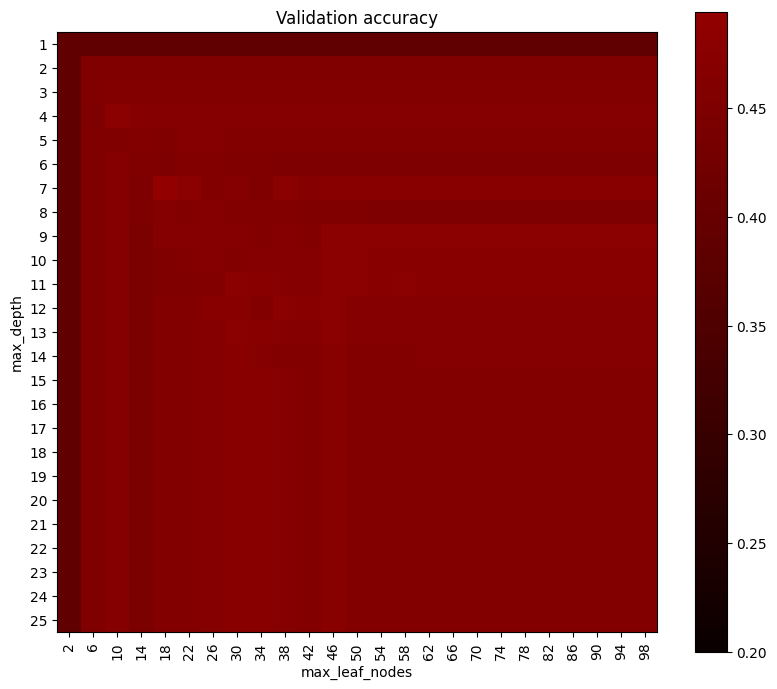

In [528]:
plotSearchGrid(grid_random_forest_classifier)

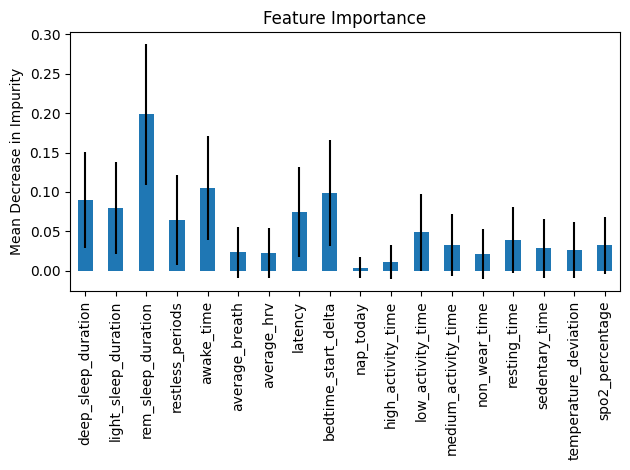

In [529]:
feat_importance = grid_random_forest_classifier.best_estimator_.feature_importances_
feat_imp_std = np.std([tree.feature_importances_ for tree in grid_random_forest_classifier.best_estimator_.estimators_], axis = 0)
forest_importances = pd.Series(feat_importance, index=bio_sleep_df.columns[4:])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr = feat_imp_std, ax = ax)
ax.set_title("Feature Importance")
ax.set_ylabel("Mean Decrease in Impurity")
fig.tight_layout()

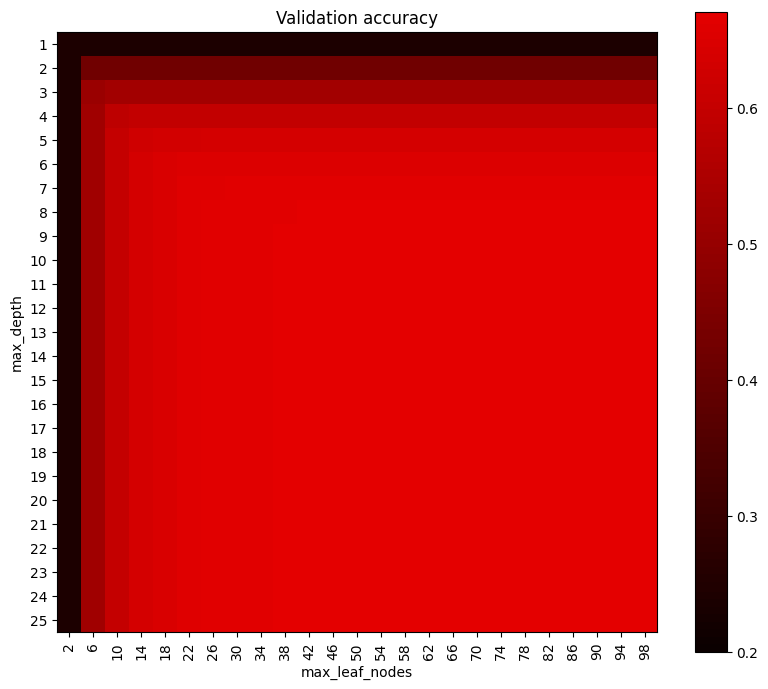

In [530]:
plotSearchGrid(grid_random_forest_regression)

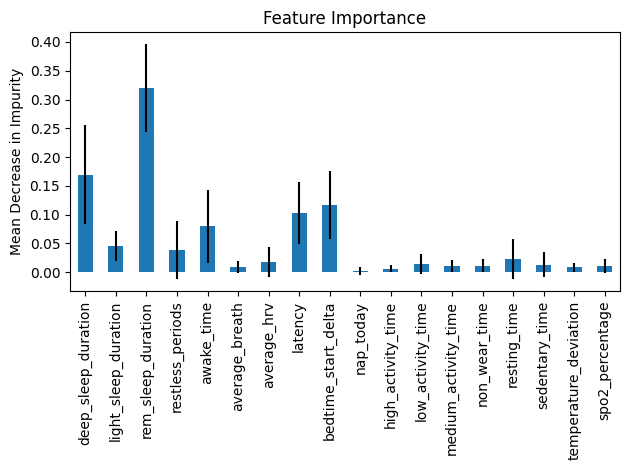

In [531]:
feat_importance = grid_random_forest_regression.best_estimator_.feature_importances_
feat_imp_std = np.std([tree.feature_importances_ for tree in grid_random_forest_regression.best_estimator_.estimators_], axis = 0)
forest_importances = pd.Series(feat_importance, index=bio_sleep_df.columns[4:])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr = feat_imp_std, ax = ax)
ax.set_title("Feature Importance")
ax.set_ylabel("Mean Decrease in Impurity")
fig.tight_layout()

### Results

---



In [539]:
def scores_classification(models):
    """Calculates and returns accuracy score from fitted classifier models.

            Parameters:
                models (list): Iterable of fitted classifier model objects.
            
            Returns:
                Dictionary where model name is the key and it's accuracy score is the value. 
                    {'model name' : accuracy}"""
    # Create dictionary to return dataframe of scores.
    model_scores = {}
    print(f'Using target variable bin interval: {bin_type}')
    for i, mod in enumerate(models):
        # Check if model is the SVC(), uses the scaled features.
        if 'SVC' in str(mod):
            X_test_temp = X_test_scaled
        else:
            X_test_temp = X_test

        model_name = str(mod).partition('(')[0]
        model_score = mod.score(X_test_temp, y_test_bin)
        # Set scores to model in dictionary.
        model_scores[model_name] = {'Accuracy': model_score}

    return model_scores

def ols_scores(model):
    """Calculates and returns regression metrics for statsmodels OLS() fitted models.

    Parameters:
        model (object): Fitted regressor model object.
    
    Returns:
        Nested dictionary where model name is the key and the model evaluation metrics are nested within. 
            {'model name' : {'R2': score,
                            'Adj_R2': score,
                            'RMSE': score,
                            'MAE': score}}"""

    y_pred = model.predict(sm.add_constant(X_test_scaled))
    r2 = model.rsquared
    adj_r2 = model.rsquared_adj
    rmse = mean_squared_error(y_test['score'], y_pred, squared = False)
    mae = mean_absolute_error(y_test['score'], y_pred)

    model_score = {'R2': r2,
                    'Adj_R2': adj_r2,
                    'RMSE': rmse,
                    'MAE': mae}

    return model_score

def scores_regression(models):
    """Calculates and returns R2, Adjusted R2, Root Mean Squared Error (RMSE), and Mean Absolute Error (MAE) from fitted regressor models.

        Parameters:
            models (list): Iterable of fitted regressor model objects.
        
        Returns:
            Nested dictionary where model name is the key and the model evaluation metrics are nested within. 
                {'model name' : {'R2': score,
                                'Adj_R2': score,
                                'RMSE': score,
                                'MAE': score}}"""
    # Create dictionary to return dataframe of scores.
    model_scores = {}

    for mod in models:
        model_name = str(mod).partition('(')[0]

        # Check if model is the SVR(), uses the scaled features.
        if 'SVR' in model_name:
            X_test_temp = X_test_scaled
        elif 'statsmodels' in model_name:
            model_scores['LinearRegression(scaled)'] = ols_scores(mod)
            continue
        else:
            X_test_temp = X_test

        y_pred = mod.predict(X_test_temp)
        r2 = mod.score(X_test_temp, y_test['score'])
        n , p = X_test_temp.shape # number of samples and predictors
        adj_r2 = 1 - (((1 - r2) * (n - 1)) / (n - p - 1))
        rmse = mean_squared_error(y_test['score'], y_pred, squared = False)
        mae = mean_absolute_error(y_test['score'], y_pred)
        # Set scores to model in dictionary.
        model_scores[model_name] = {'R2': r2,
                                    'Adj_R2': adj_r2,
                                    'RMSE': rmse,
                                    'MAE': mae}

    return model_scores

def plot_predictions_vs_score_regression(models):
    """Prints to output (n x 3) subplot array of each model's predicted sleep scores and observed (truth) sleep scores for each X_test, y_test pair, sorted by descending sleep score.
    (where n = number of model objects). Can handle any number of input models.

    Parameters:
        models (list): Iterable of fitted regressor model objects.
    
    Returns:
        None. Prints plot to output."""
    
    fig, ax = plt.subplots(int(np.ceil(len(models) / 3)), 3, figsize = (12, 8))
    for i, mod in enumerate(models):
        # Check if model is the SVR() or OLS(), uses the scaled features.
        if 'SVR' in str(mod):
            X_test_temp = X_test_scaled
        else:
            X_test_temp = X_test

        if 'statsmodels' in str(mod):
            temp_scores = ols_scores(mod)
            y_pred = mod.predict(sm.add_constant(X_test_scaled))
            r2 = temp_scores['R2']
            adj_r2 = temp_scores['Adj_R2']
            rmse = temp_scores['RMSE']
            mae = temp_scores['MAE']
            model_name = 'LinearRegression(scaled)'
        else:
            y_pred = mod.predict(X_test_temp)
            r2 = mod.score(X_test_temp, y_test['score'])
            n , p = X_test_temp.shape # number of samples and predictors
            adj_r2 = 1 - (((1 - r2) * (n - 1)) / (n - p - 1))
            rmse = mean_squared_error(y_test['score'], y_pred, squared = False)
            mae = mean_absolute_error(y_test['score'], y_pred)
            model_name = str(mod).partition('(')[0]

        results = list(zip(y_pred, y_test['score']))
        results = sorted(results, key = lambda x: x[1], reverse = True)
        
        ax[i // 3, i % 3].plot(results, alpha = 0.85, drawstyle = 'steps')
        ax[i // 3, i % 3].set_xlabel('Index (sorted)')
        ax[i // 3, i % 3].set_ylabel('Sleep Score')
        ax[i // 3, i % 3].set_title(model_name)
        ax[i // 3, i % 3].grid(alpha = 0.4)
        ax[i // 3, i % 3].text(x = 0.1, 
                            y = 0.2, 
                            transform = ax[i // 3, i % 3].transAxes,
                            s = (f"{mae:0.3f} - MAE"
                            '\n'f"{rmse:0.3f} - RMSE"
                            '\n'f"{r2:0.3f} - R2"
                            '\n'f"{adj_r2:0.3f} - Adj_R2"))
        # Check if odd number of models and delete last subplot if true.
    if len(models) % 2 != 0:
        fig.delaxes(ax[len(models) // 3, (len(models) % 3)])
        
    plt.subplots_adjust(wspace = 0.2, hspace = 0.4)
    fig.legend(['Predicted', 'Truth'], loc = 'upper right')
    fig.suptitle('Predicted Score and True Score', fontsize = 12)

    return None

def plot_obs_vs_pred_regression(models):
    """Prints to output (n x 3) subplot array of each model's observed vs predicted plots.
    (where n = number of model objects). Can handle any number of input models.

    Parameters:
        models (list): Iterable of fitted regressor model objects.
    
    Returns:
        None. Prints plot to output."""
    
    fig, ax = plt.subplots(int(np.ceil(len(models) / 3)), 3, figsize = (11, 7))
    for i, mod in enumerate(models):
        # Check if model is the SVR(), uses the scaled features.
        if 'SVR' in str(mod):
            X_test_temp = X_test_scaled
        else:
            X_test_temp = X_test

        if 'statsmodels' in str(mod):
            y_pred = mod.predict(sm.add_constant(X_test_scaled))
            model_name = 'LinearRegression(scaled)'
        else:
            y_pred = mod.predict(X_test_temp)
            model_name = str(mod).partition('(')[0]

        ax[i // 3, i % 3].scatter(y_pred, y_test['score'], alpha = 0.5)
        ax[i // 3, i % 3].plot(np.arange(min(y_test['score']), 100, 1), np.arange(min(y_test['score']), 100, 1), 'k--', alpha = 0.6)
        ax[i // 3, i % 3].set_xlabel('Predictions')
        ax[i // 3, i % 3].set_ylabel('Observations')
        ax[i // 3, i % 3].set_title(model_name)
        ax[i // 3, i % 3].grid(alpha = 0.4)

        # Check if odd number of models and delete last subplot if true.
    if len(models) % 2 != 0:
        fig.delaxes(ax[len(models) // 3, (len(models) % 3)])
        
    plt.subplots_adjust(wspace = 0.3, hspace = 0.4)
    fig.suptitle('Observed (Truth) vs Predicted', fontsize = 12)

    return None

def plot_models_roc(models):
    """Prints to output (n x 3) subplot array of each model's ROC curve plot.
    (where n = number of model objects). Can handle any number of input models.

    Parameters:
        models (list): Iterable of fitted classifier model objects.
    
    Returns:
        None. Prints plot to output."""
    # Need to use LabelBinarizer() since we have multiple classes.
    label_binarizer = LabelBinarizer().fit(y_train_bin)
    y_onehot_test = label_binarizer.transform(y_test_bin)
    for mod in models:
        if 'Ridge' in str(mod): # Can't calculate probabilities in Ridge.
            continue
        if 'SVC' in str(mod): # Use scaled X_test values
            y_scores = mod.predict_proba(X_test_scaled)
        else:
            y_scores = mod.predict_proba(X_test)
        fpr, tpr, _ = roc_curve(y_onehot_test.ravel(), y_scores.ravel())
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label = f"{str(mod).partition('(')[0]} - AUC = {auc_score:0.2f}")

    plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k--')
    plt.title('ROC - Micro-Average OvR')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(alpha = 0.4)
    plt.legend(loc = 'lower right')
    
    return None

# Function to iterate through classification models and plot confusion matrix together.
def plot_models_confusion_matrix(models):
    """Prints to output (n x 3) subplot array of each model's confusion matrix.
    (where n = number of model objects). Can handle any number of input models.

    Parameters:
        models (list): Iterable of fitted classifier model objects.
    
    Returns:
        None. Prints plot to output."""
    fig, ax = plt.subplots(int(np.ceil(len(models) / 3)), 3, figsize = (10, 8), sharey = True)
    for i, mod in enumerate(models):
        # Check if model is the SVC(), uses the scaled features.
        if 'SVC' in str(mod):
            X_test_temp = X_test_scaled 
        else:
            X_test_temp = X_test

        cm = confusion_matrix(y_test_bin, mod.predict(X_test_temp), labels = y_test_bin.sort_values().unique())
        disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = y_test_bin.sort_values().unique())
        disp.plot(ax = ax[i // 3, i % 3], xticks_rotation = 90)
        disp.ax_.set_title(str(mod).partition('(')[0])
        disp.im_.colorbar.remove()

    # Check if odd number of models and delete last subplot if true.
    if len(models) % 2 != 0:
        fig.delaxes(ax[i // 3, (len(models) % 3)])
    fig.tight_layout()
    plt.subplots_adjust(wspace = 0.2, hspace = 0)
    fig.colorbar(disp.im_, ax = ax)
    fig.suptitle('Confusion Matrices of Classifier Models')
    
    return None

In [533]:
regression_scores = scores_regression(models_regression)
display(pd.DataFrame(regression_scores).T.sort_values(by = 'MAE'))

,R2,Adj_R2,RMSE,MAE
Lasso,0.877107,0.834568,3.158493,2.361737
Ridge,0.876964,0.834375,3.160329,2.369043
LinearRegression(scaled),0.875232,0.866660,3.161564,2.370275
LinearRegression,0.876868,0.834246,3.161564,2.370275
SVR,0.859844,0.811329,3.373044,2.513705
RandomForestRegressor,0.804870,0.737324,3.979966,2.948306


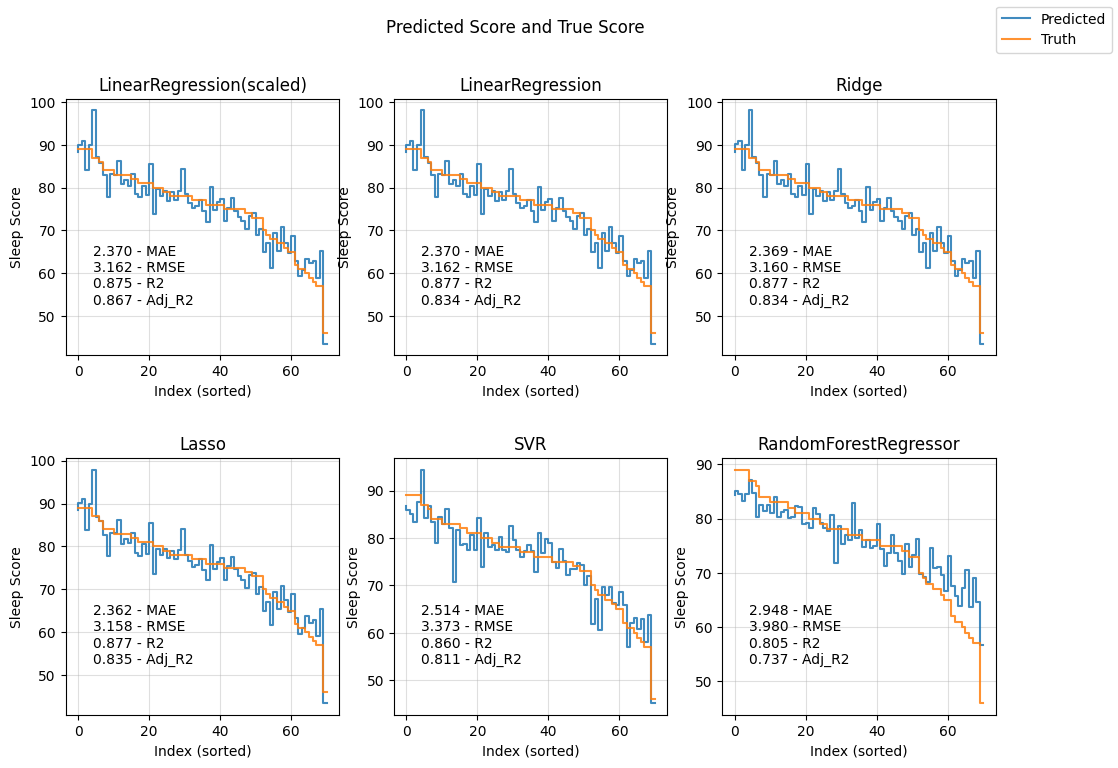

In [534]:
plot_predictions_vs_score_regression(models_regression)

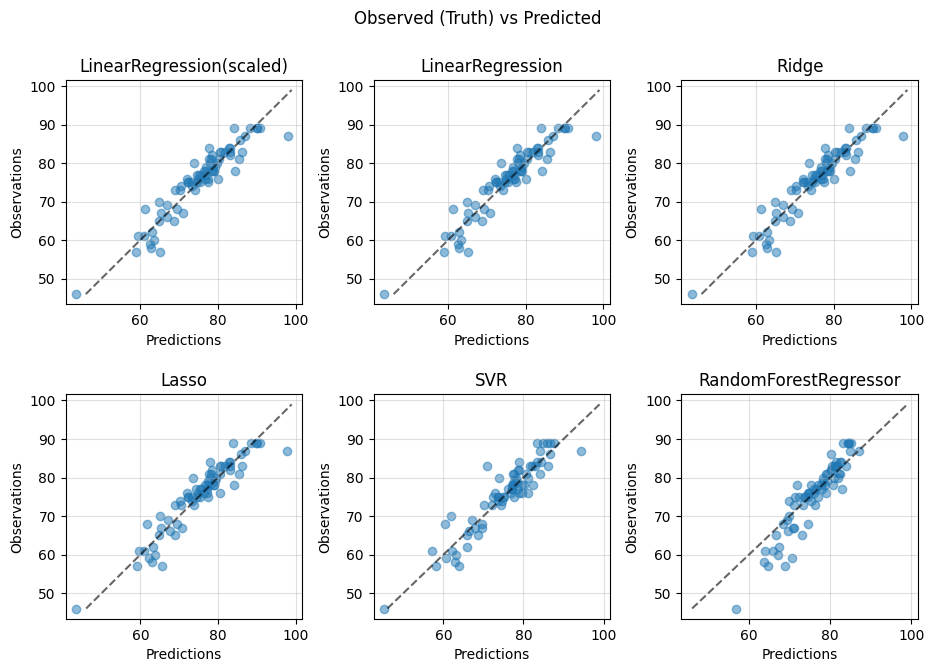

In [535]:
plot_obs_vs_pred_regression(models_regression)

In [536]:
classification_scores = scores_classification(models_classification)
display(pd.DataFrame(classification_scores).T.sort_values(by = 'Accuracy', ascending = False))

Using target variable bin interval: score_bin_quantile


,Accuracy
LogisticRegression,0.647887
SVC,0.647887
RidgeClassifier,0.507042
AdaBoostClassifier,0.507042
RandomForestClassifier,0.492958
DecisionTreeClassifier,0.464789


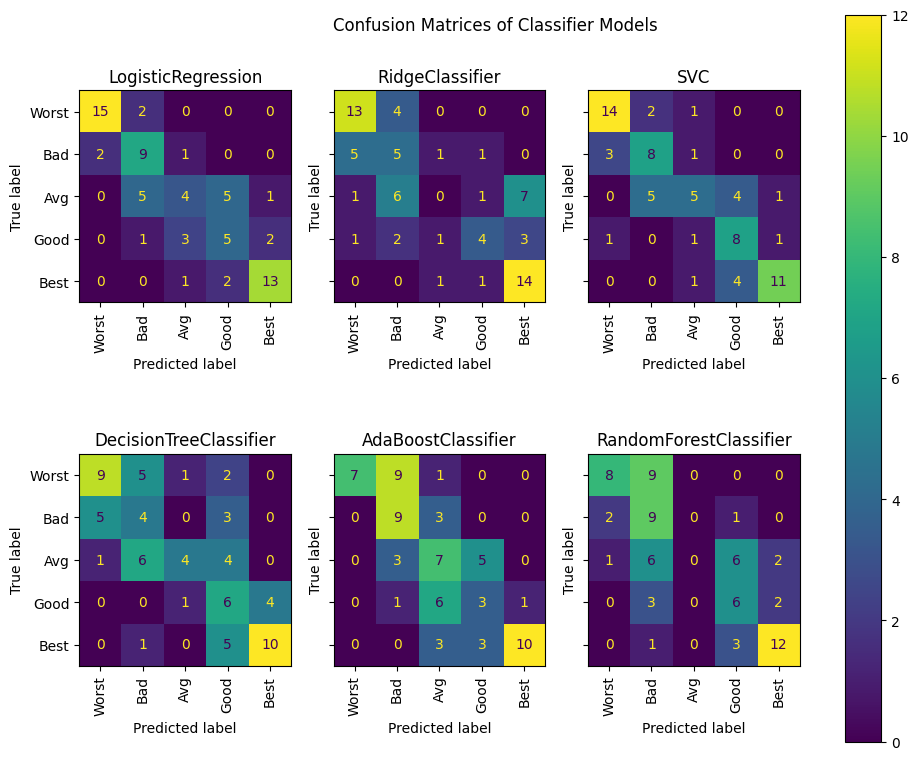

In [537]:
plot_models_confusion_matrix(models_classification)

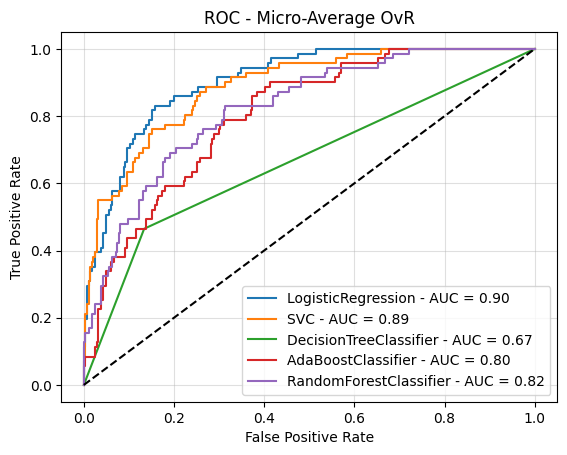

In [538]:
plot_models_roc(models_classification)

### Conclusion

---

